# 

In [1]:
# pip install pmdarima
# pip install sktime
# pip install statsmodels

In [2]:
#importing necessary modules

import datetime 
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import numpy.linalg

import yfinance as yf
import pandas as pd

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler

from sktime.split import temporal_train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima 



In [3]:
# 12-month data from 1983-01-01' to 2023-01-01'
##
FY2024_START='1983-01-01'
FY2024_END='2023-01-01'
KOTicker='KO'

In [4]:
KOData= yf.download(KOTicker, start=FY2024_START,end=FY2024_END)

[*********************100%***********************]  1 of 1 completed


In [5]:
KOData.head()

Price                     Adj Close     Close      High       Low      Open  \
Ticker                           KO        KO        KO        KO        KO   
Date                                                                          
1983-01-03 00:00:00+00:00  0.360310  1.062500  1.098958  1.059896  1.083333   
1983-01-04 00:00:00+00:00  0.362076  1.067708  1.070313  1.052083  1.062500   
1983-01-05 00:00:00+00:00  0.361193  1.065104  1.080729  1.059896  1.067708   
1983-01-06 00:00:00+00:00  0.363842  1.072917  1.088542  1.065104  1.065104   
1983-01-07 00:00:00+00:00  0.363842  1.072917  1.083333  1.067708  1.072917   

Price                        Volume  
Ticker                           KO  
Date                                 
1983-01-03 00:00:00+00:00   7228800  
1983-01-04 00:00:00+00:00  12441600  
1983-01-05 00:00:00+00:00   7694400  
1983-01-06 00:00:00+00:00   8347200  
1983-01-07 00:00:00+00:00   6628800

In [6]:
df_KO_close = KOData['Close'].KO

In [7]:
df_KO_close.shape

(10084,)

In [8]:
df_KO_close.describe()

count    10084.000000
mean        25.238184
std         16.625822
min          0.963542
25%         10.250000
50%         24.938750
75%         38.626250
max         66.209999
Name: KO, dtype: float64

In [9]:
df_KO_close.isna().sum()

0

<AxesSubplot: >

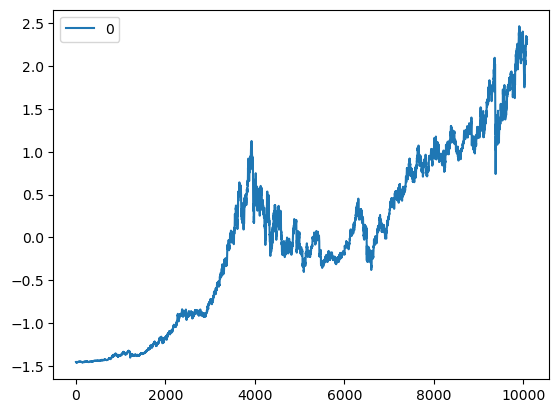

In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_KO_close.values.reshape(-1, 1)) 
scaled_series= pd.DataFrame(scaled_data)
scaled_series.plot()

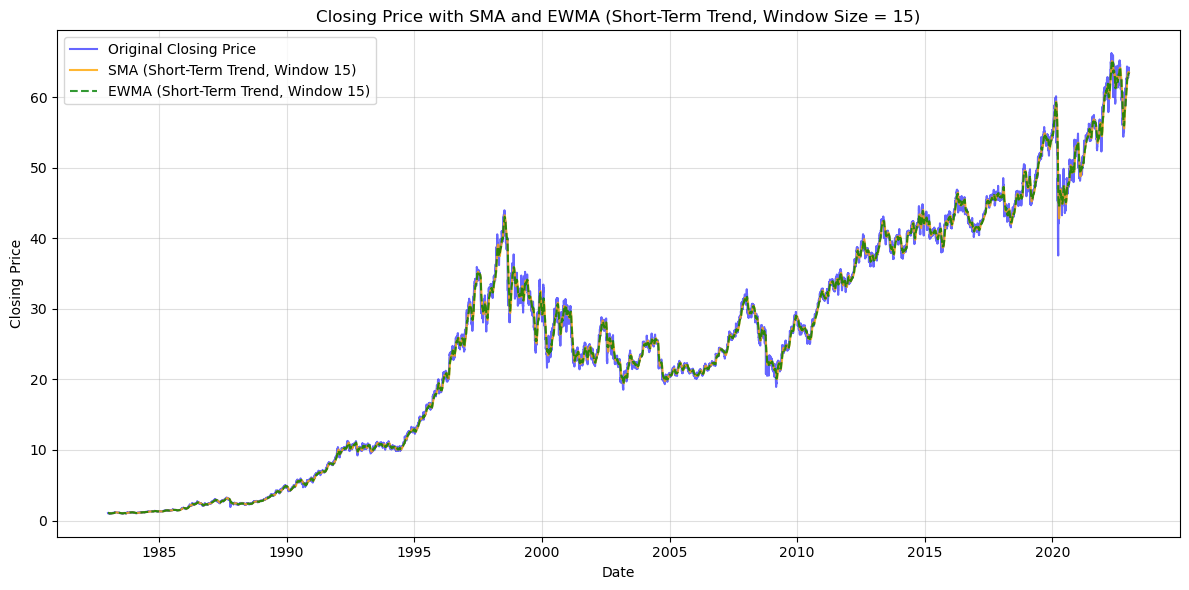

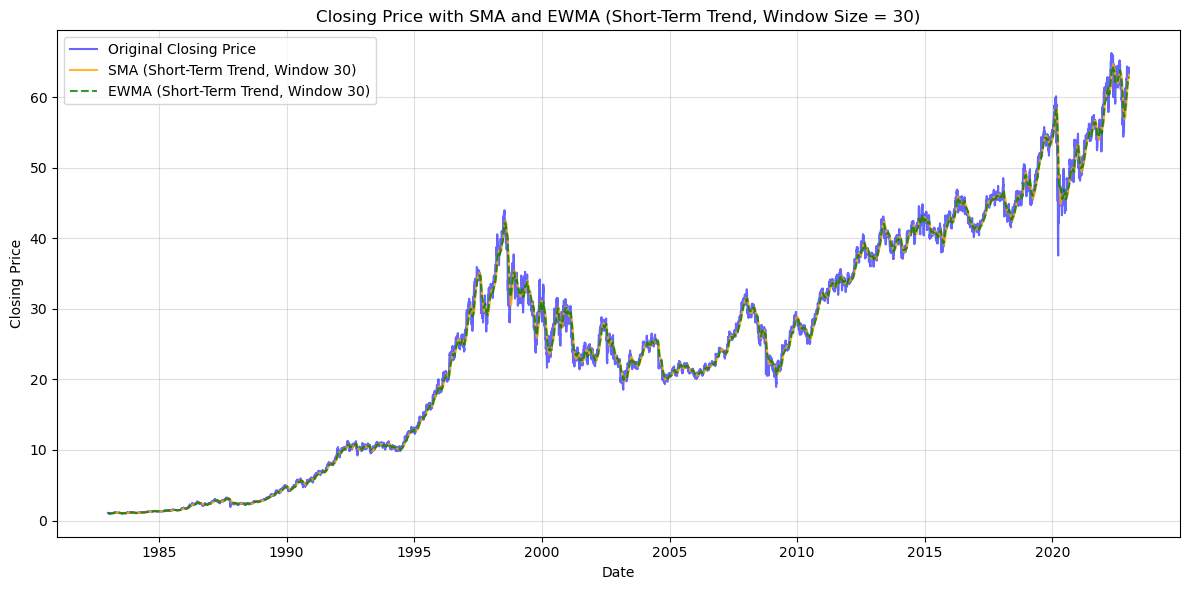

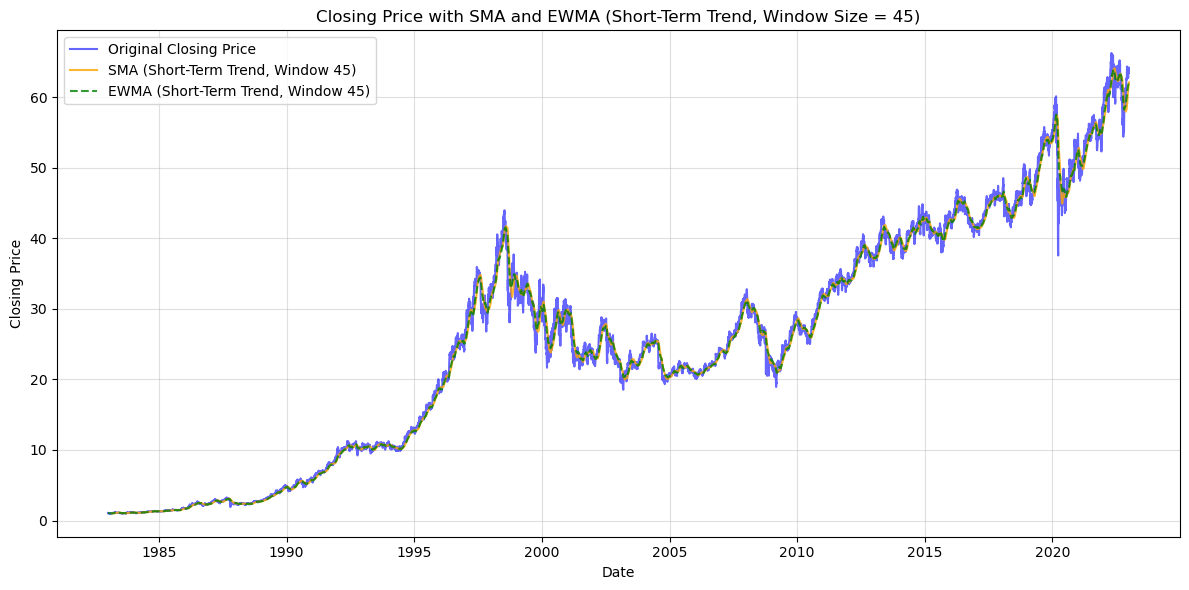

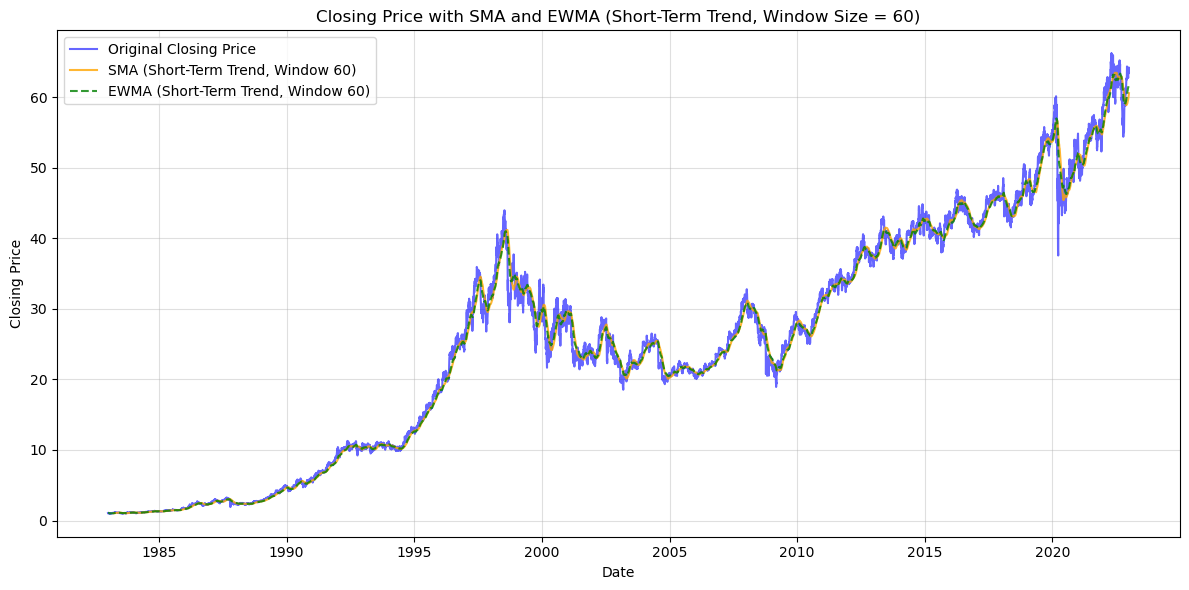

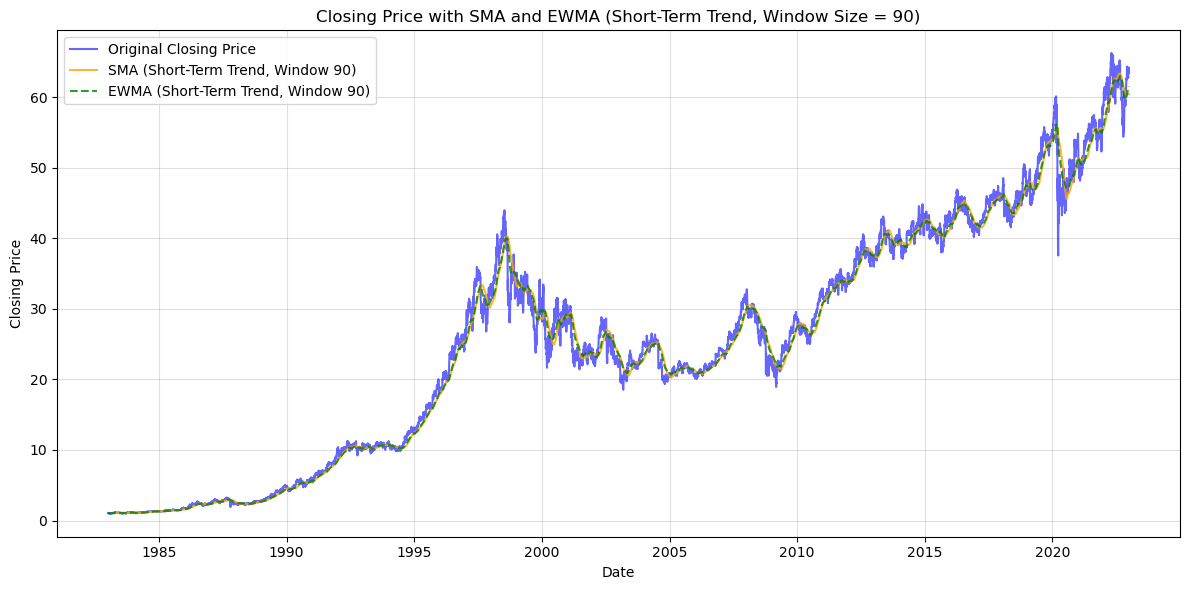

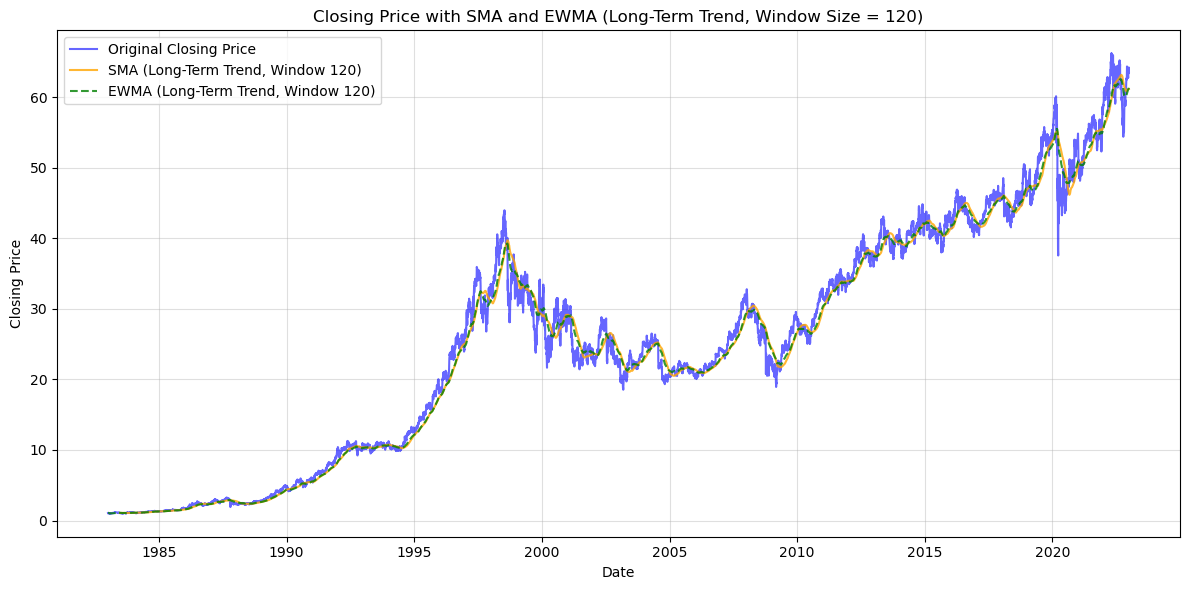

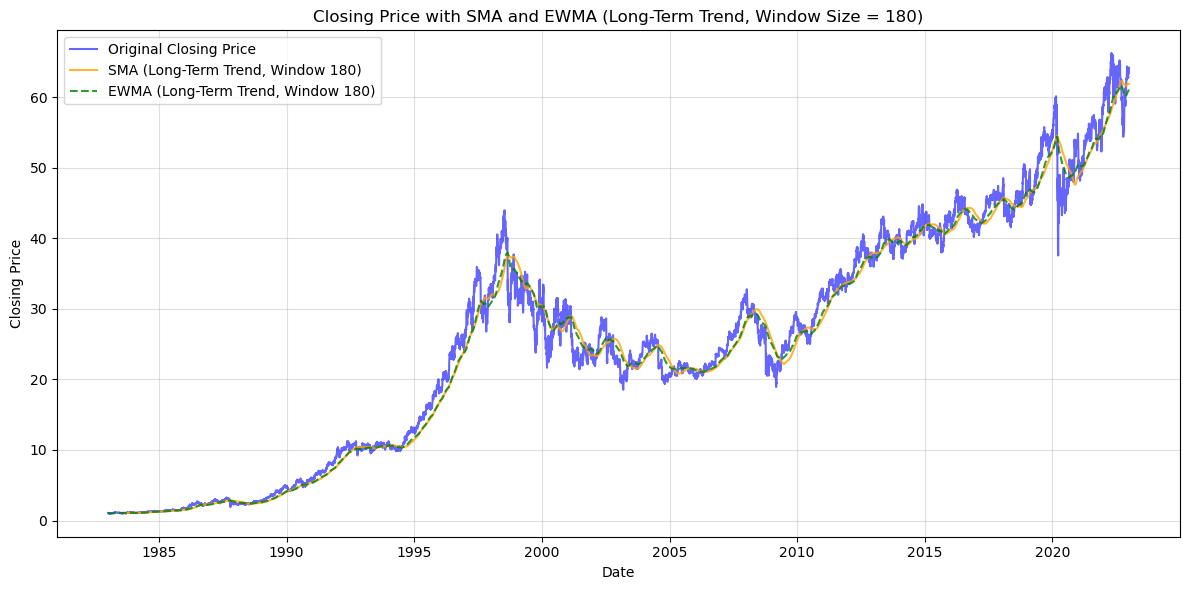

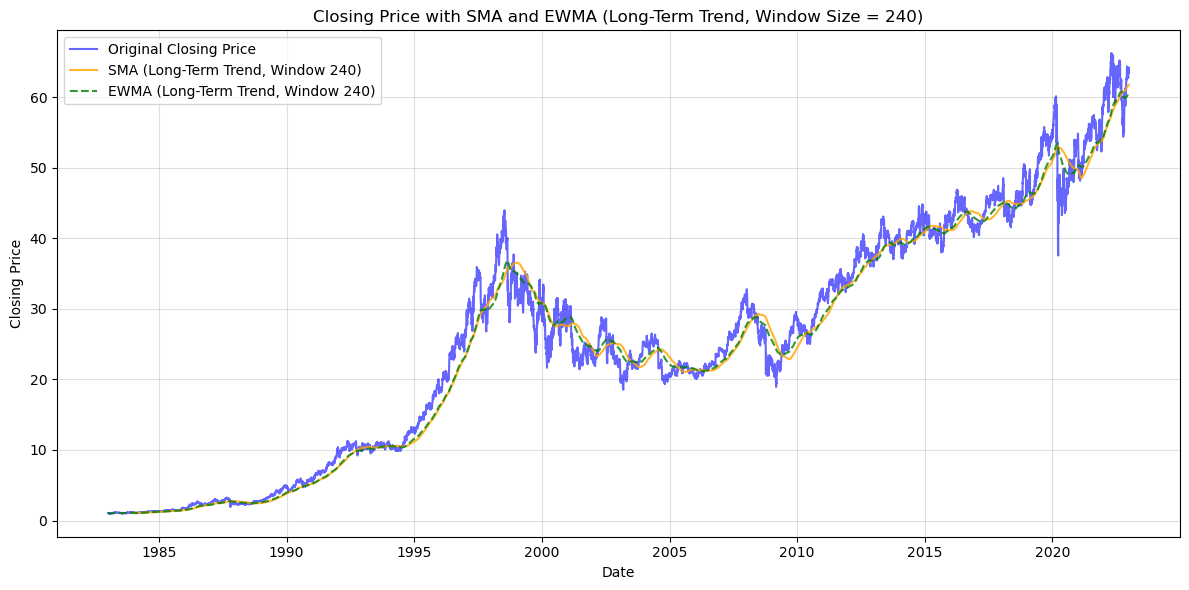

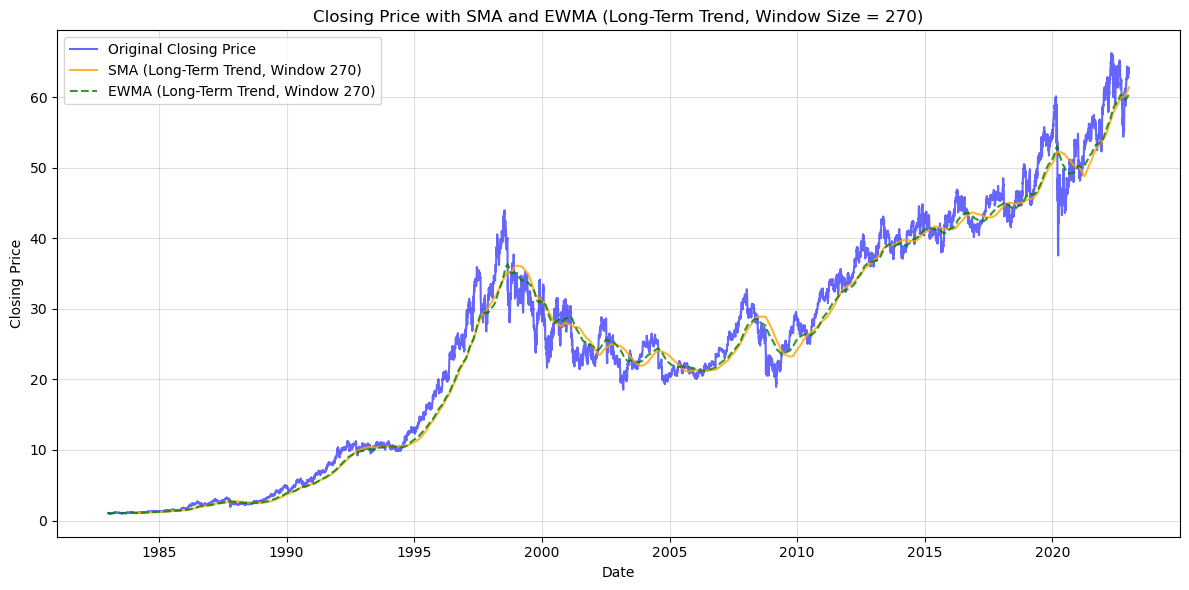

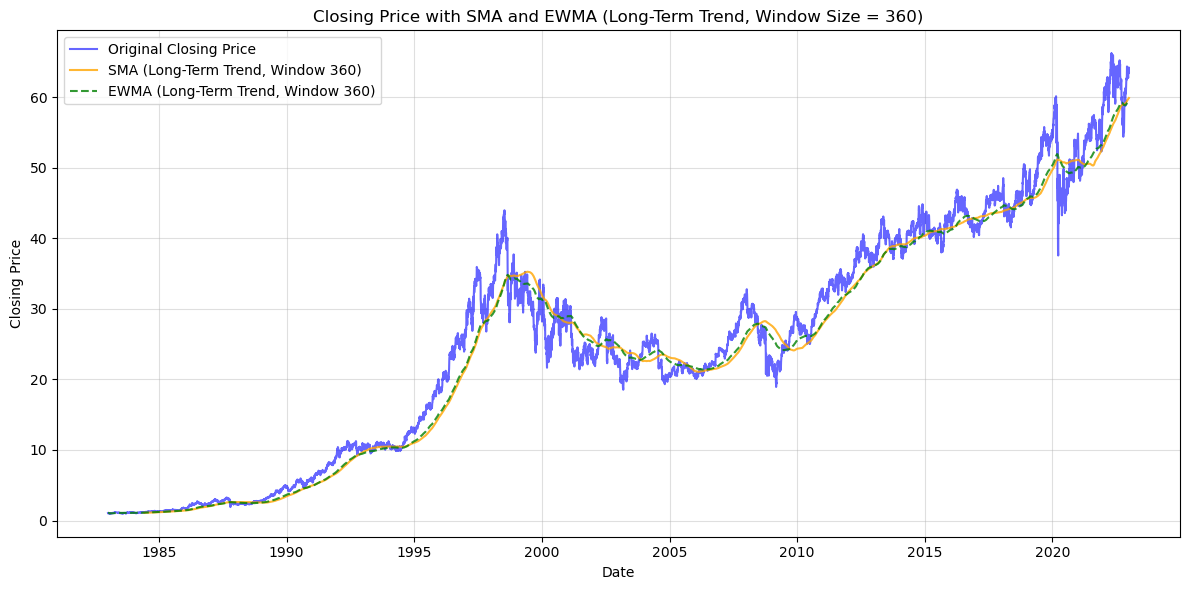

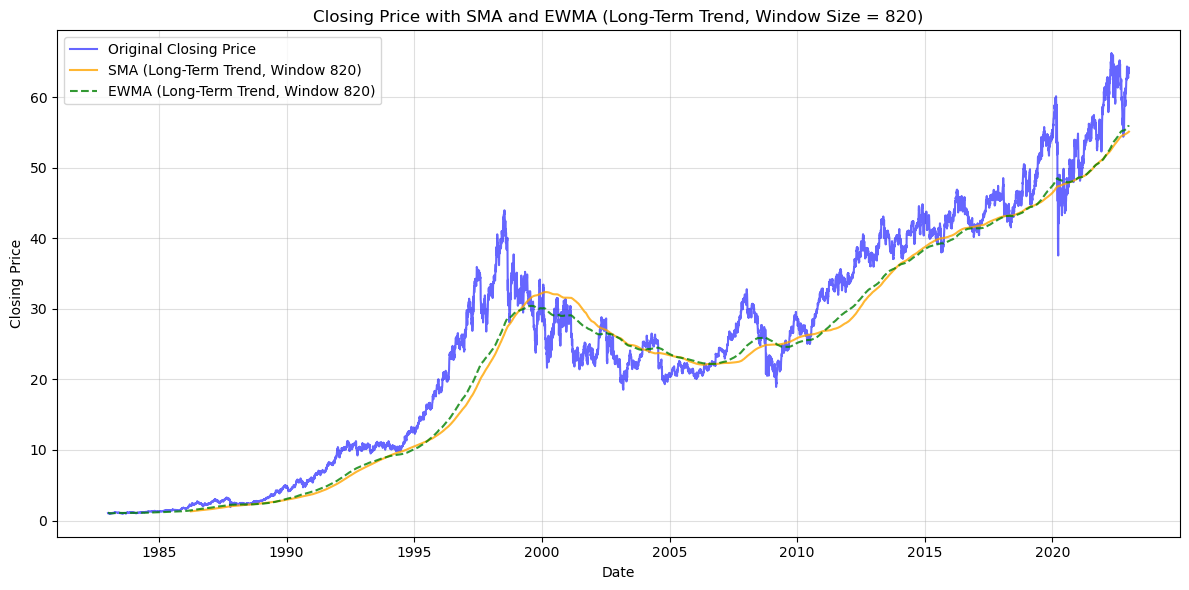

In [11]:
# Visualizing Closing Price, SMA, and EWMA with additional short-term and long-term windows

# Define window sizes for short-term, long-term, and experimental predictions
window_sizes = {
    "Short-Term Trend": [15, 30, 45, 60, 90 ],  # Expanding short-term ranges
    "Long-Term Trend": [120, 180, 240, 270, 360, 820],  # Expanding long-term ranges
}

# Loop through each trend type and its associated window sizes
for trend_type, windows in window_sizes.items():
    for window in windows:
        plt.figure(figsize=(12, 6))  # Initialize a new figure for each window size

        # Plot the original closing price
        plt.plot(df_KO_close, label="Original Closing Price", color="blue", alpha=0.6)

        # Calculate and plot the SMA
        sma = df_KO_close.rolling(window=window).mean()
        plt.plot(sma, label=f"SMA ({trend_type}, Window {window})", color="orange", alpha=0.8)

        # Calculate and plot the EWMA
        ewma = df_KO_close.ewm(span=window).mean()
        plt.plot(ewma, label=f"EWMA ({trend_type}, Window {window})", color="green", linestyle="--", alpha=0.8)

        # Add title and labels for each trend type and window size
        plt.title(f"Closing Price with SMA and EWMA ({trend_type}, Window Size = {window})")
        plt.xlabel("Date")
        plt.ylabel("Closing Price")
        plt.legend()
        plt.grid(alpha=0.4)

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Comments on what to observe:
        # - **Short-Term Windows (15, 30, 45, 60, 90)**:
        #   - Look for increasing smoothness as the window size grows.
        #   - Smaller windows capture sharper movements and volatility.
        #   - Larger short-term windows provide intermediate smoothing for short-term trends.
        #
        # - **Long-Term Windows (120, 180, 240, 270, 360)**:
        #   - Look for overarching patterns that become more evident with longer windows.
        #   - Compare overlapping trends from smaller and larger long-term windows.
        #
        # - **Goal**:
        #   - Use these insights to make an educated prediction for suitable business life cycle windows.


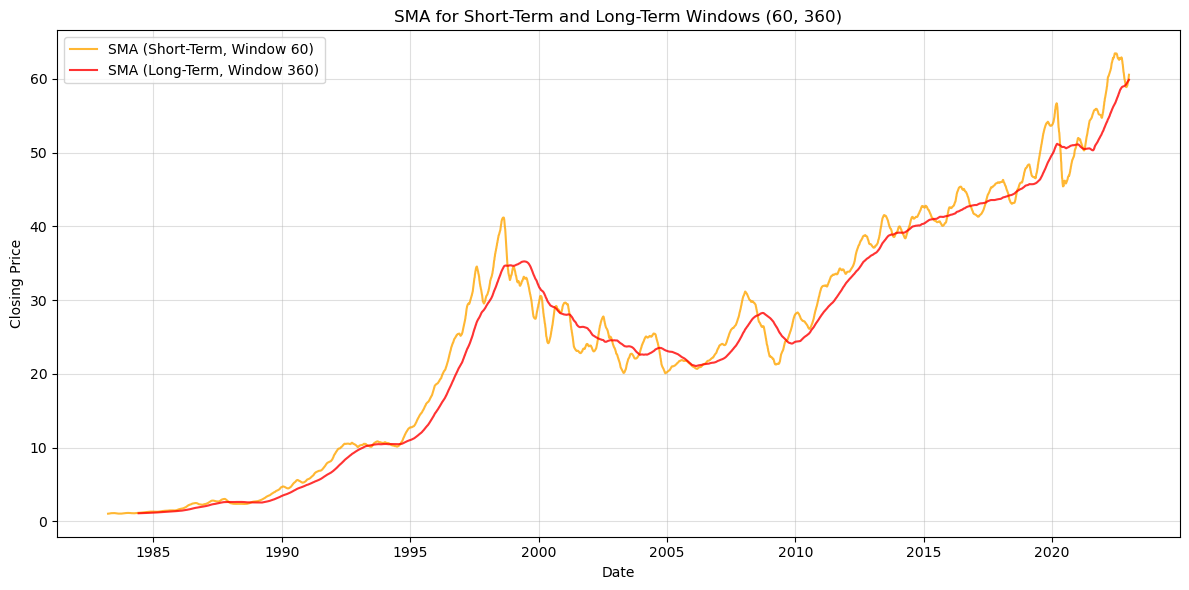

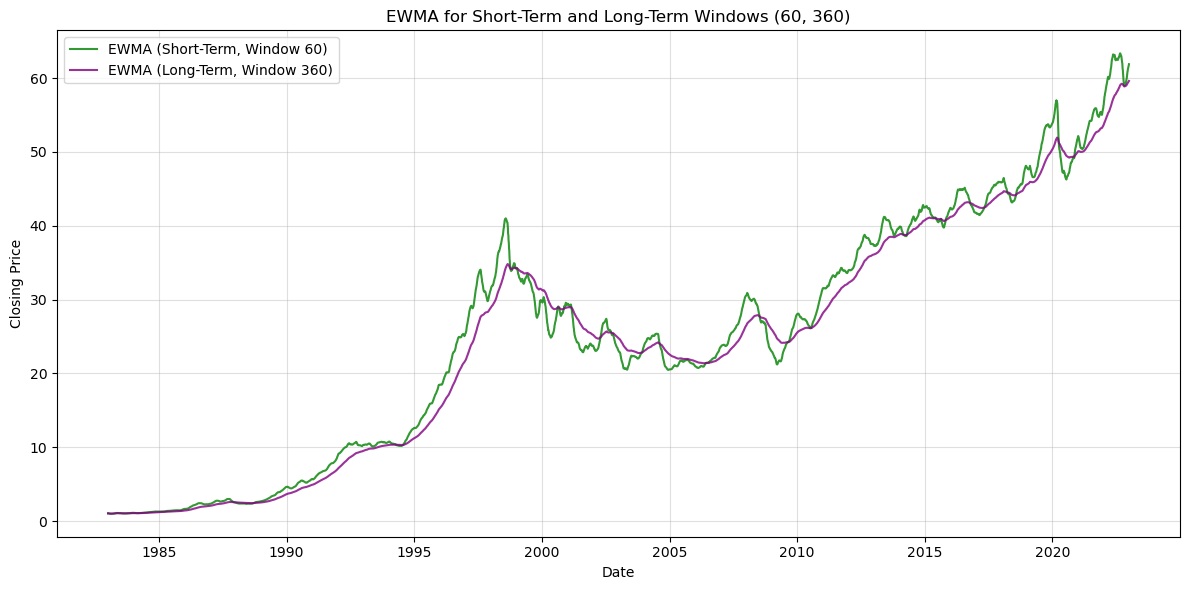

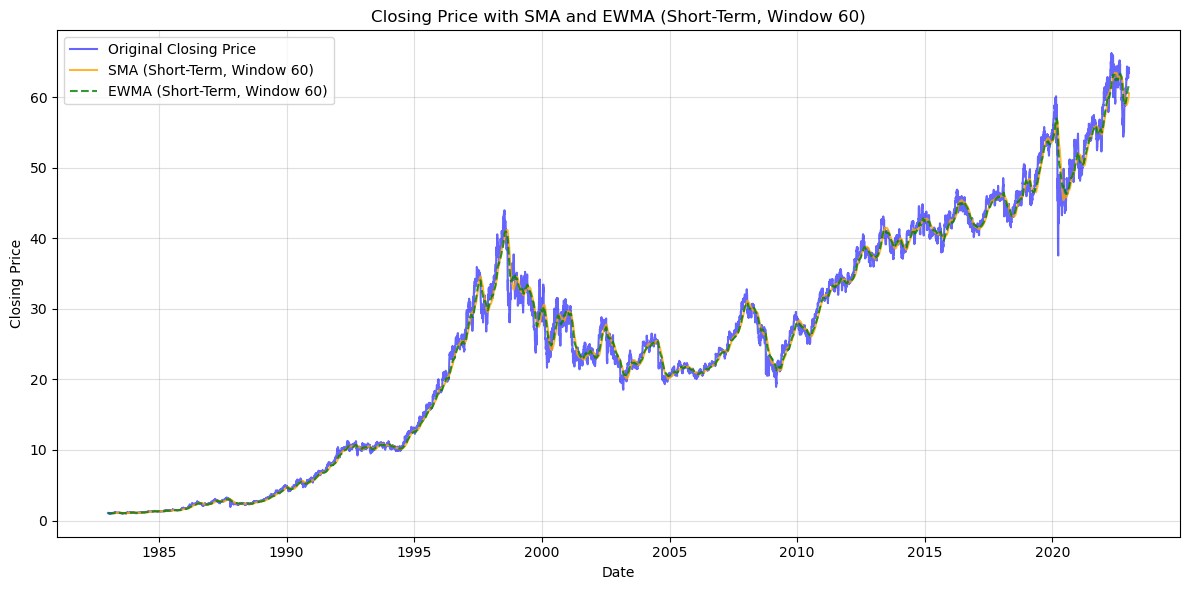

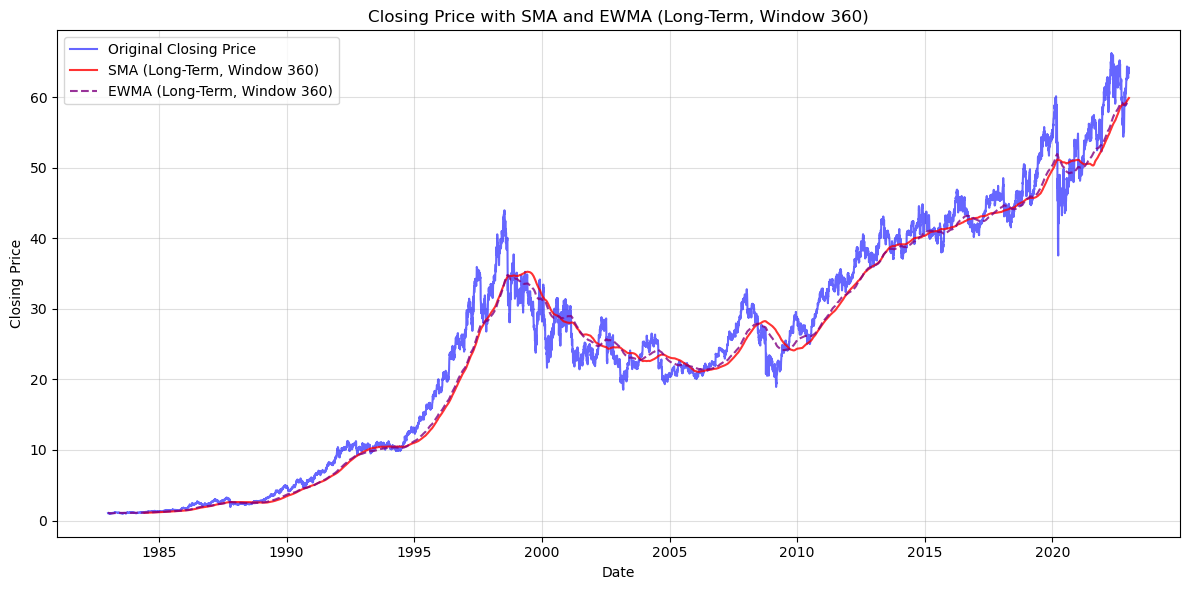

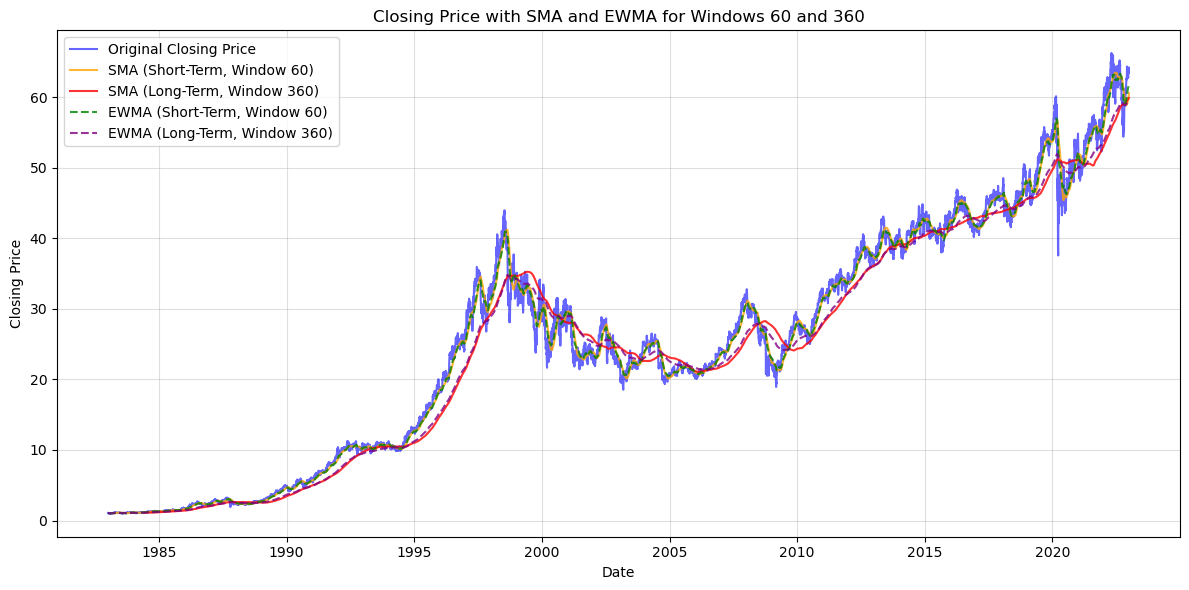

In [12]:
# Visualizing Closing Price, SMA, and EWMA with specified short-term and long-term windows

# Define the selected window sizes for short-term and long-term trends
short_term_window = 60
long_term_window = 360

# Plot SMA for all specified windows
plt.figure(figsize=(12, 6))

# Calculate and plot SMA for the short-term window
sma_short = df_KO_close.rolling(window=short_term_window).mean()
plt.plot(sma_short, label=f"SMA (Short-Term, Window {short_term_window})", color="orange", alpha=0.8)

# Calculate and plot SMA for the long-term window
sma_long = df_KO_close.rolling(window=long_term_window).mean()
plt.plot(sma_long, label=f"SMA (Long-Term, Window {long_term_window})", color="red", alpha=0.8)

# Add title, labels, and legend
plt.title(f"SMA for Short-Term and Long-Term Windows ({short_term_window}, {long_term_window})")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Plot EWMA for all specified windows
plt.figure(figsize=(12, 6))

# Calculate and plot EWMA for the short-term window
ewma_short = df_KO_close.ewm(span=short_term_window).mean()
plt.plot(ewma_short, label=f"EWMA (Short-Term, Window {short_term_window})", color="green", alpha=0.8)

# Calculate and plot EWMA for the long-term window
ewma_long = df_KO_close.ewm(span=long_term_window).mean()
plt.plot(ewma_long, label=f"EWMA (Long-Term, Window {long_term_window})", color="purple", alpha=0.8)

# Add title, labels, and legend
plt.title(f"EWMA for Short-Term and Long-Term Windows ({short_term_window}, {long_term_window})")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Plot SMA, EWMA, and Closing Price for the short-term window
plt.figure(figsize=(12, 6))

# Plot the original closing price
plt.plot(df_KO_close, label="Original Closing Price", color="blue", alpha=0.6)

# Plot SMA and EWMA for the short-term window
plt.plot(sma_short, label=f"SMA (Short-Term, Window {short_term_window})", color="orange", alpha=0.8)
plt.plot(ewma_short, label=f"EWMA (Short-Term, Window {short_term_window})", color="green", linestyle="--", alpha=0.8)

# Add title, labels, and legend
plt.title(f"Closing Price with SMA and EWMA (Short-Term, Window {short_term_window})")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Plot SMA, EWMA, and Closing Price for the long-term window
plt.figure(figsize=(12, 6))

# Plot the original closing price
plt.plot(df_KO_close, label="Original Closing Price", color="blue", alpha=0.6)

# Plot SMA and EWMA for the long-term window
plt.plot(sma_long, label=f"SMA (Long-Term, Window {long_term_window})", color="red", alpha=0.8)
plt.plot(ewma_long, label=f"EWMA (Long-Term, Window {long_term_window})", color="purple", linestyle="--", alpha=0.8)

# Add title, labels, and legend
plt.title(f"Closing Price with SMA and EWMA (Long-Term, Window {long_term_window})")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Plot all (SMA, EWMA, and Closing Price) in the same graph
plt.figure(figsize=(12, 6))

# Plot the original closing price
plt.plot(df_KO_close, label="Original Closing Price", color="blue", alpha=0.6)

# Plot SMA for both windows
plt.plot(sma_short, label=f"SMA (Short-Term, Window {short_term_window})", color="orange", alpha=0.8)
plt.plot(sma_long, label=f"SMA (Long-Term, Window {long_term_window})", color="red", alpha=0.8)

# Plot EWMA for both windows
plt.plot(ewma_short, label=f"EWMA (Short-Term, Window {short_term_window})", color="green", linestyle="--", alpha=0.8)
plt.plot(ewma_long, label=f"EWMA (Long-Term, Window {long_term_window})", color="purple", linestyle="--", alpha=0.8)

# Add title, labels, and legend
plt.title(f"Closing Price with SMA and EWMA for Windows {short_term_window} and {long_term_window}")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [13]:
# Visualization of Transformations in Time Series Data
# This function visualizes transformations like removing outliers, smoothing, and differencing to reveal trends and patterns.
# Each step includes an explanation of the purpose and effect of the transformation.

def visTransformations(df_data, dataName, windowSize):
    plt.figure(figsize=(30, 90))

    # 1. Raw Time Series
    # Displays the original data to observe its overall behavior, including patterns and trends, before applying any transformations.
    plt.subplot(10, 1, 1)
    df_data.plot()
    plt.title(f'{dataName} - Raw Time Series')

    # 2. Removing Outliers
    # Outliers are extreme values that distort analysis. This step filters data points beyond 2 standard deviations from the mean.
    plt.subplot(10, 1, 2)
    z_scores = zscore(df_data)
    filtered_data = (np.abs(z_scores) < 1.96)  # Threshold for outliers
    series_no_outliers = df_data[filtered_data]
    series_no_outliers.plot()
    plt.title(f'{dataName} - Outliers Removed')

    # 3. Histogram (Distribution)
    # Visualizes the frequency distribution of data values, helping to understand the spread and central tendencies.
    plt.subplot(10, 1, 3)
    plt.hist(df_data, bins=20)
    plt.title(f'{dataName} - Value Distribution')

    # 4. Rolling Average
    # Smooths data by averaging over a window, highlighting trends by reducing noise from short-term fluctuations.
    plt.subplot(10, 1, 4)
    df_data.rolling(windowSize).mean().plot()
    plt.title(f'{dataName} - Rolling Average (Window={windowSize})')

    # 5. Rolling Standard Deviation
    # Measures variability within a window. Highlights periods of high or low variability, which may indicate seasonality or volatility.
    plt.subplot(10, 1, 5)
    df_data.rolling(windowSize).std().plot()
    plt.title(f'{dataName} - Rolling Std Dev (Window={windowSize})')

    # 6. First-Order Differencing
    # Calculates differences between consecutive points to remove trends, emphasizing short-term changes or fluctuations.
    plt.subplot(10, 1, 6)
    df_data.diff().plot()
    plt.title(f'{dataName} - First Difference')

    # 7. Higher-Order Differencing
    # Removes deeper trends or persistent patterns over time. This can make the data stationary for better modeling.
    DIFF_ORDER = 20
    plt.subplot(10, 1, 7)
    df_diff = df_data.copy()
    for _ in range(DIFF_ORDER):
        df_diff = df_diff.diff()
    df_diff.plot()
    plt.title(f'{dataName} - {DIFF_ORDER}th Difference')

    # 8. Rolling Mean of Differenced Data
    # Combines rolling average with differencing to smooth out short-term fluctuations and emphasize remaining trends.
    plt.subplot(10, 1, 8)
    df_data.diff().rolling(windowSize).mean().plot()
    plt.title(f'{dataName} - Rolling Mean of Differenced Data (Window={windowSize})')

    # 9. Rolling Std Dev of Differenced Data
    # Measures the variability of changes over time, useful for analyzing consistency in short-term variations.
    plt.subplot(10, 1, 9)
    df_data.diff().rolling(windowSize).std().plot()
    plt.title(f'{dataName} - Rolling Std Dev of Differenced Data (Window={windowSize})')

    # 10. Scaled and Filtered Data
    # Standardizes data to have a mean of 0 and standard deviation of 1, useful for comparing data on different scales or preparing for modeling.
    plt.subplot(10, 1, 10)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(series_no_outliers.values.reshape(-1, 1))
    plt.plot(scaled_data)
    plt.title(f'{dataName} - Scaled and Filtered Data')


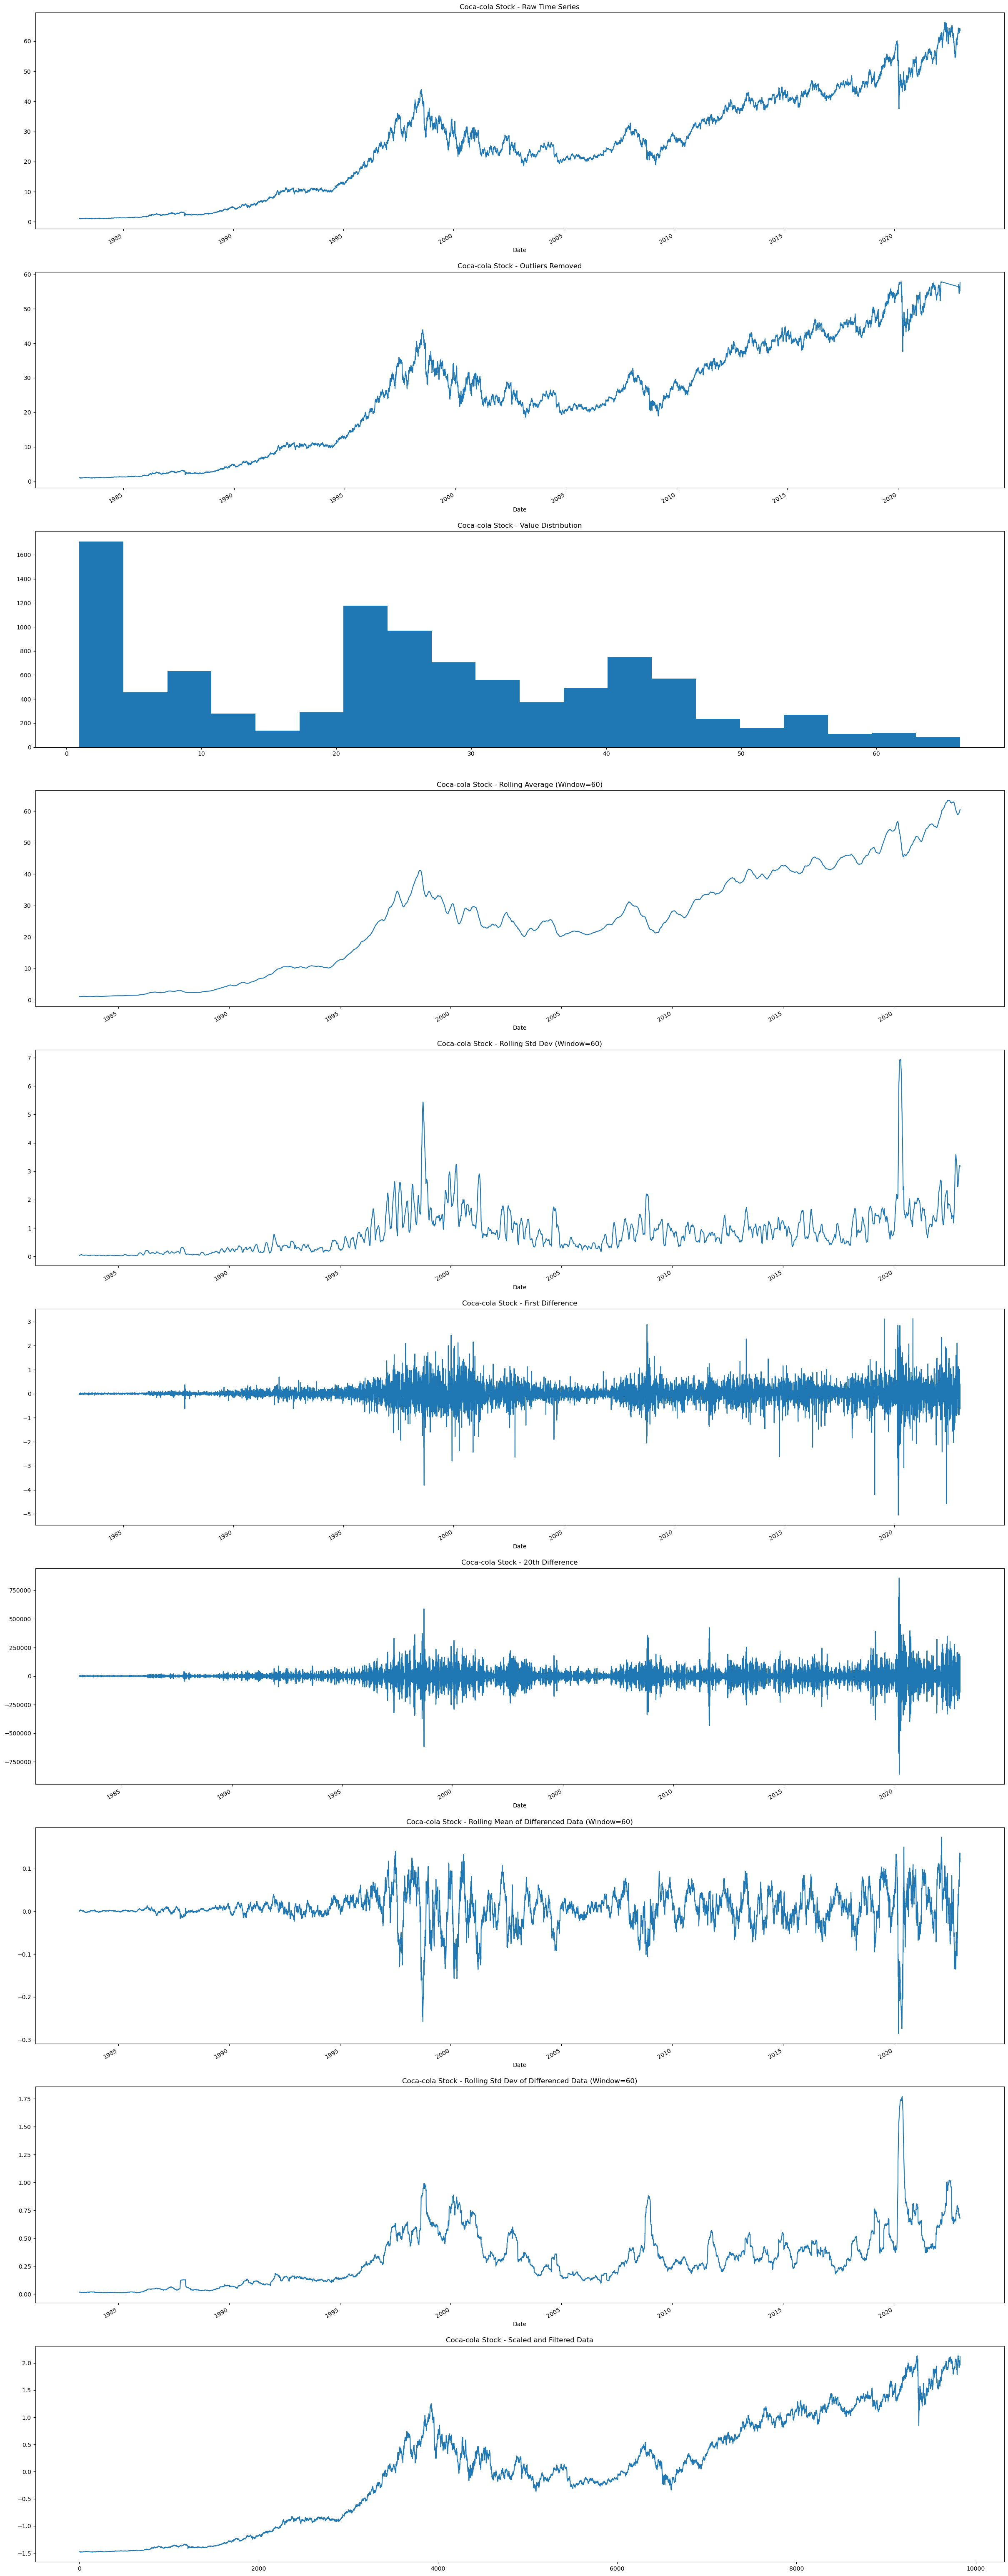

In [14]:
visTransformations(df_KO_close,'Coca-cola Stock',60)

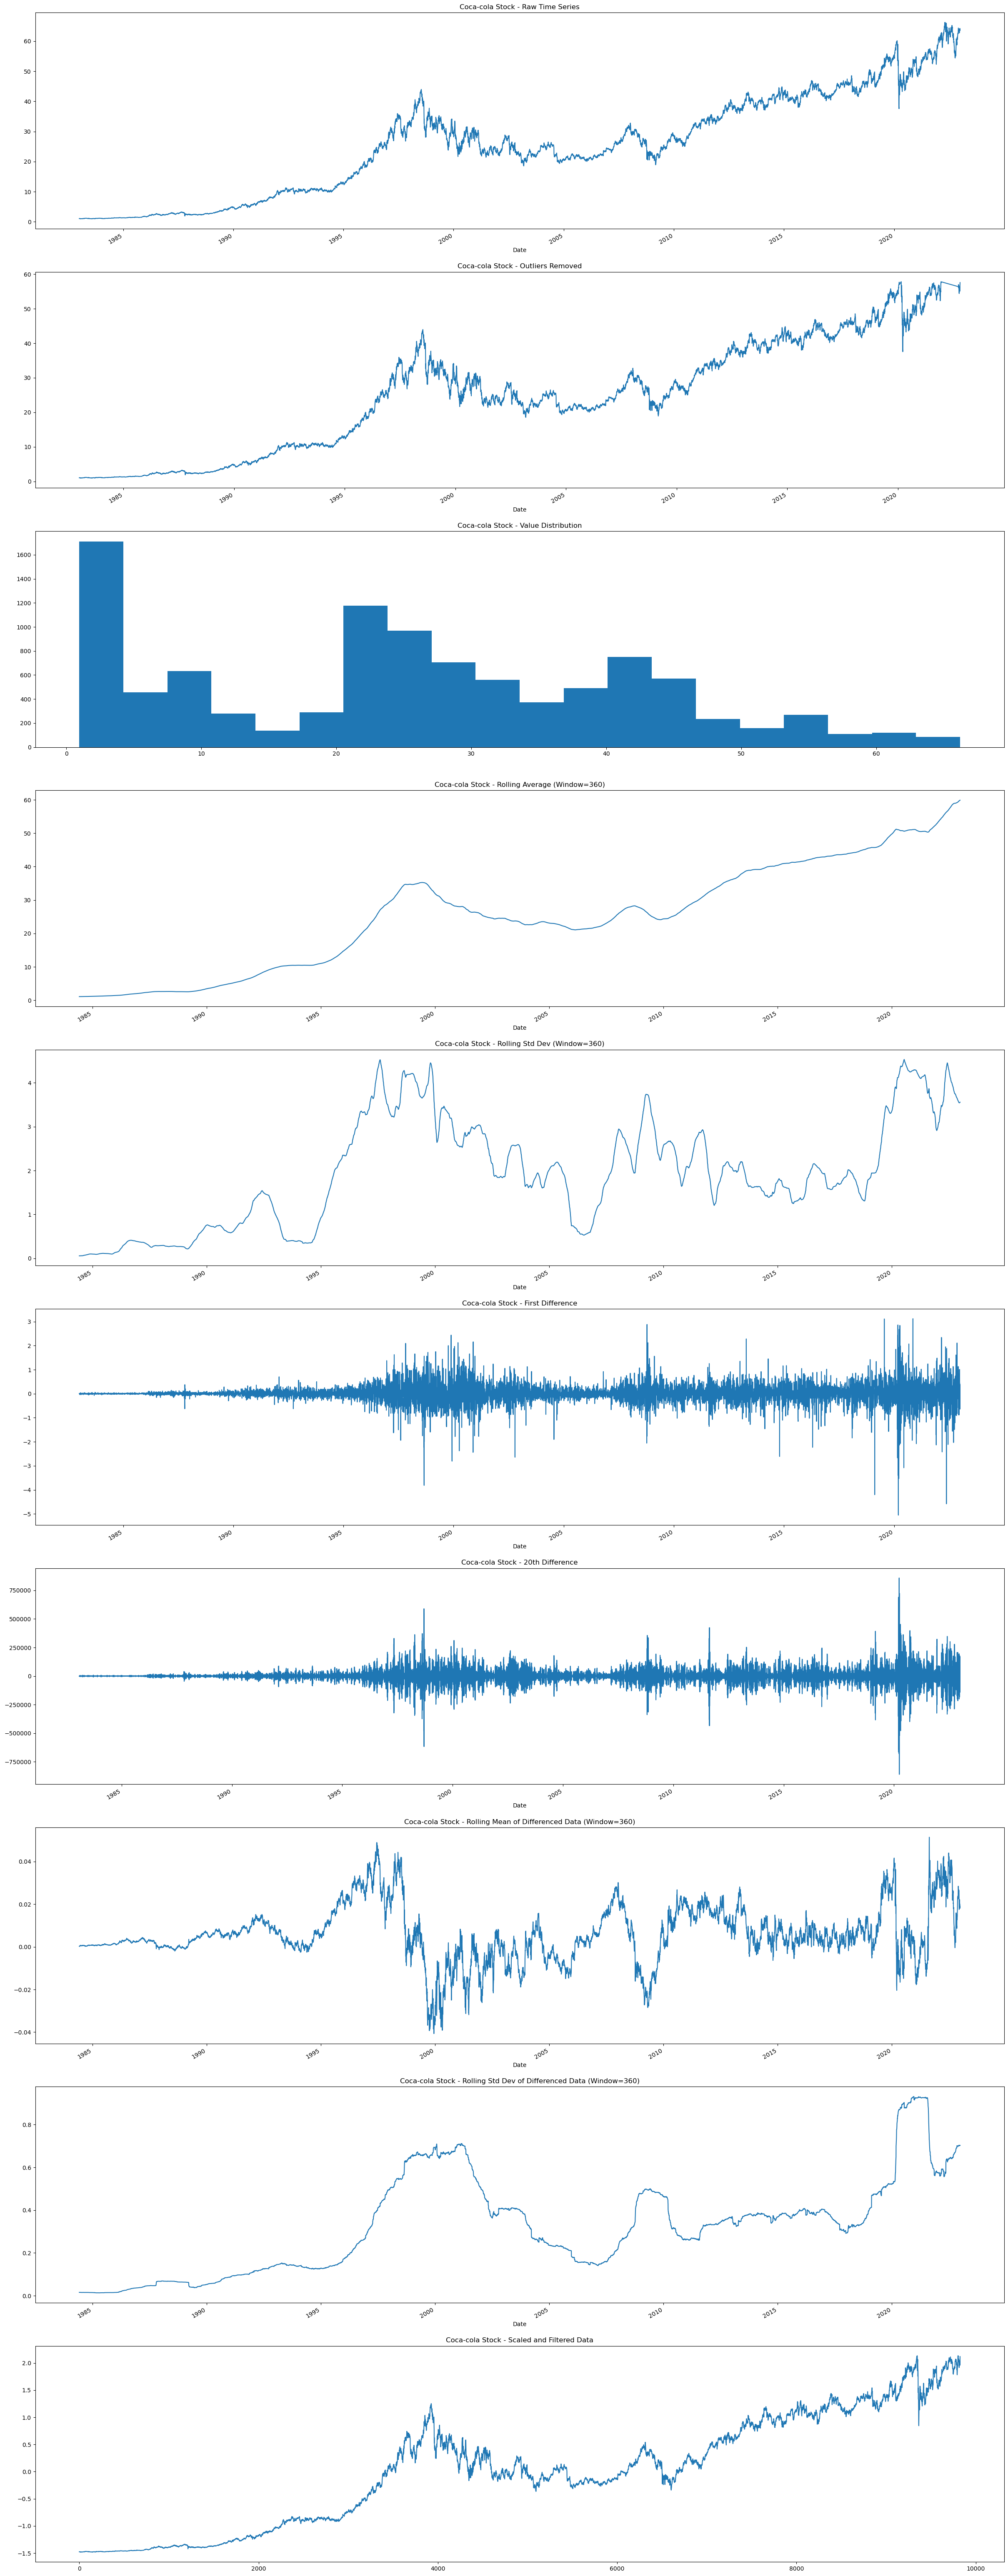

In [15]:
visTransformations(df_KO_close,'Coca-cola Stock',360)

Text(0.5, 1.0, 'Coca-Cola - Outliers Removed')

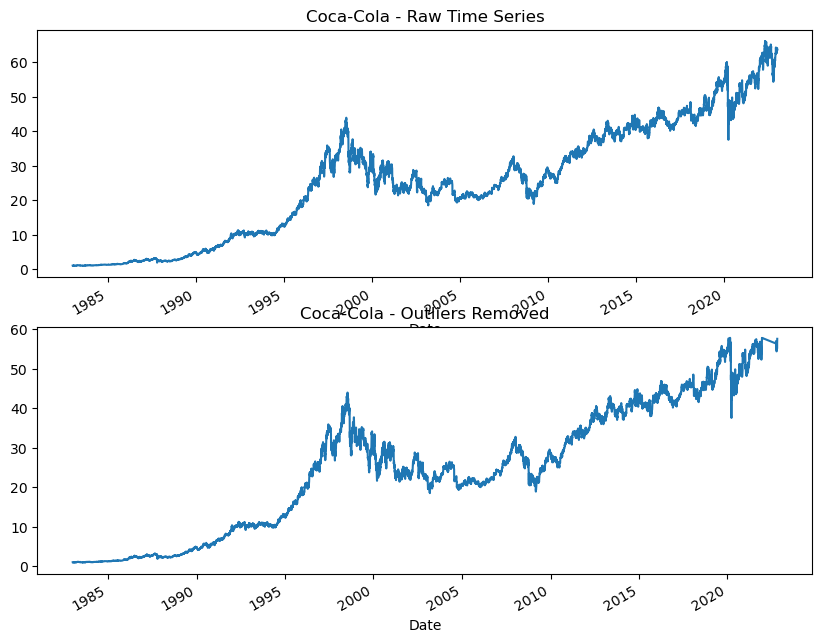

In [16]:
plt.figure(figsize=(10, 8)) 
# Displays the original data to observe its overall behavior, including patterns and trends, before applying any transformations.
plt.subplot(2, 1, 1)
df_KO_close.plot()
plt.title(f'{"Coca-Cola"} - Raw Time Series')

# 2. Removing Outliers
# Outliers are extreme values that distort analysis. This step filters data points beyond 2 standard deviations from the mean.
plt.subplot(2, 1, 2)
z_scores = zscore(df_KO_close)
filtered_data = (np.abs(z_scores) < 1.96)  # Threshold for outliers
series_no_outliers = df_KO_close[filtered_data]
series_no_outliers.plot()
plt.title(f'{"Coca-Cola"} - Outliers Removed')



In [17]:
# We wont be removing outliers as it makes the graph lose potentially useful data

<Figure size 3000x1000 with 0 Axes>

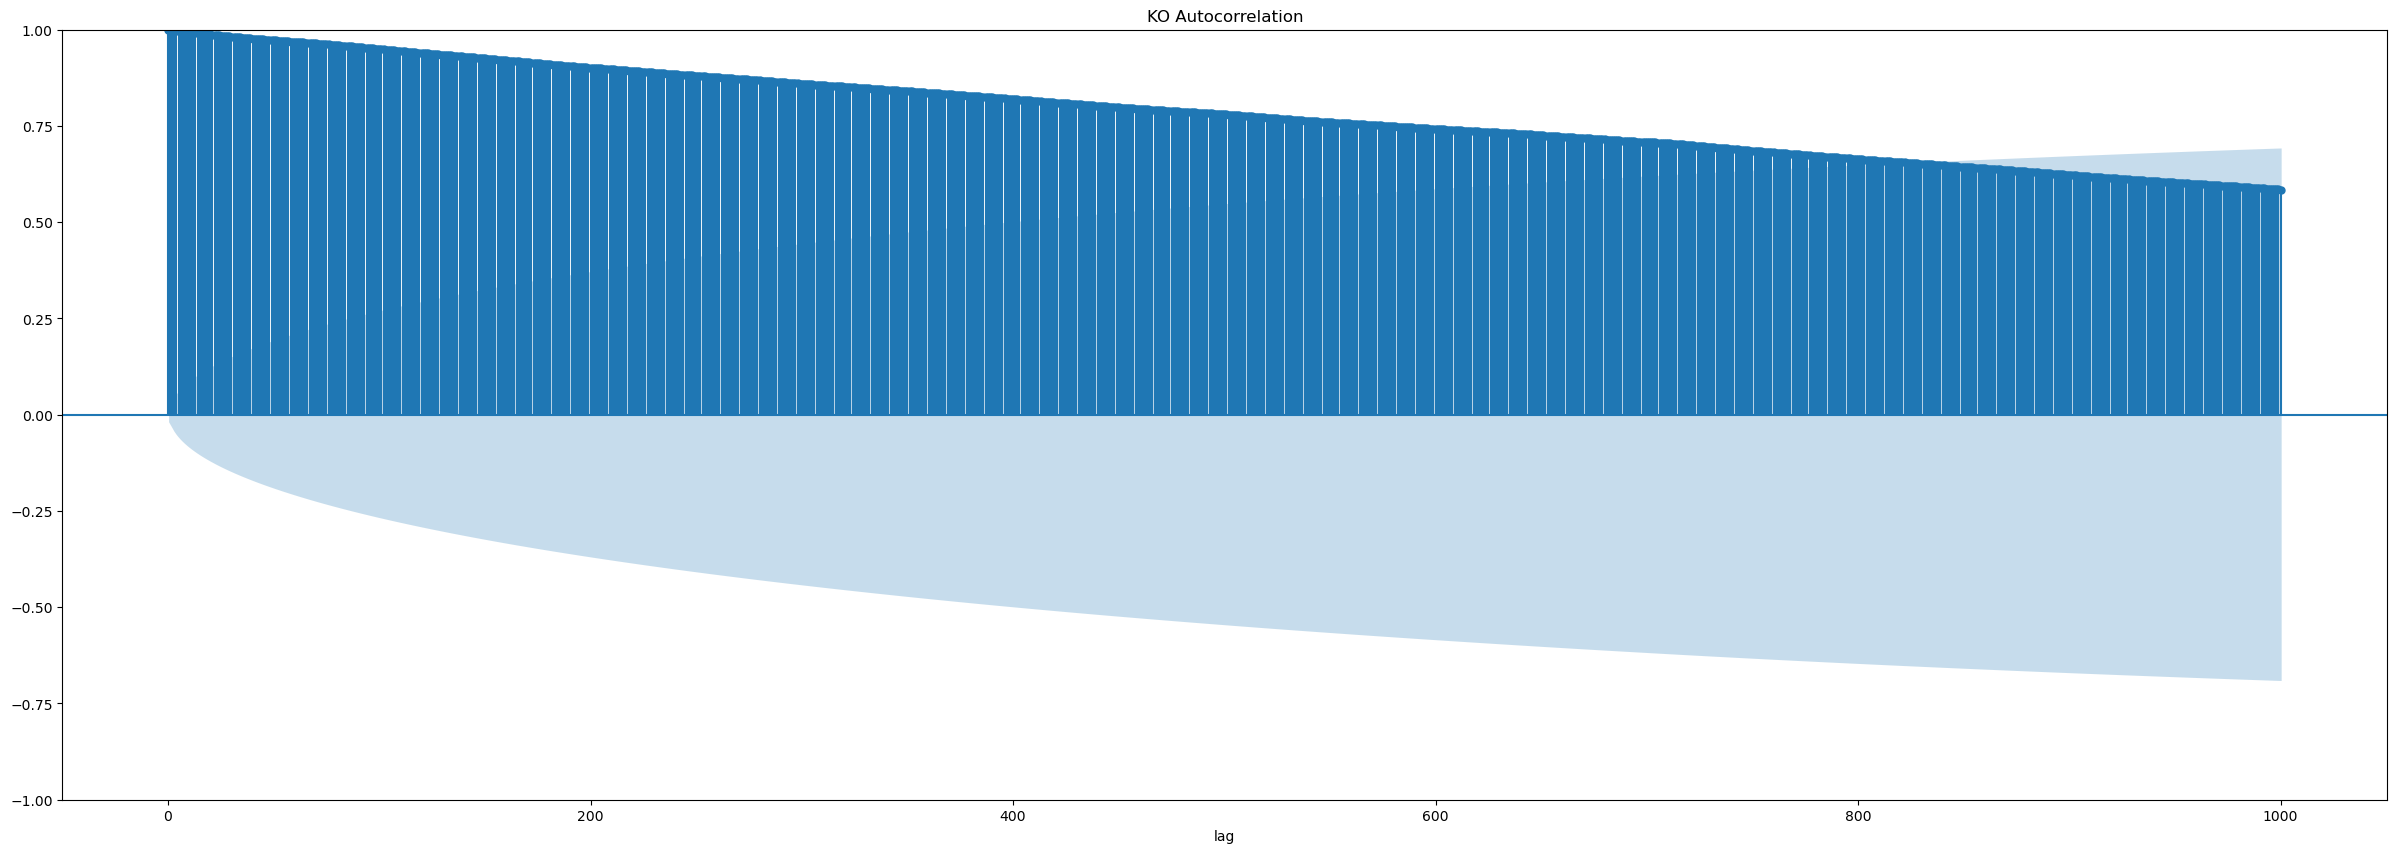

In [18]:
# ACF Non-stationary data
plt.figure(3,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_KO_close, lags=1000, title='KO Autocorrelation',alpha=0.05,ax=ax);

# BUSINESS CYCLES

[*********************100%***********************]  1 of 1 completed


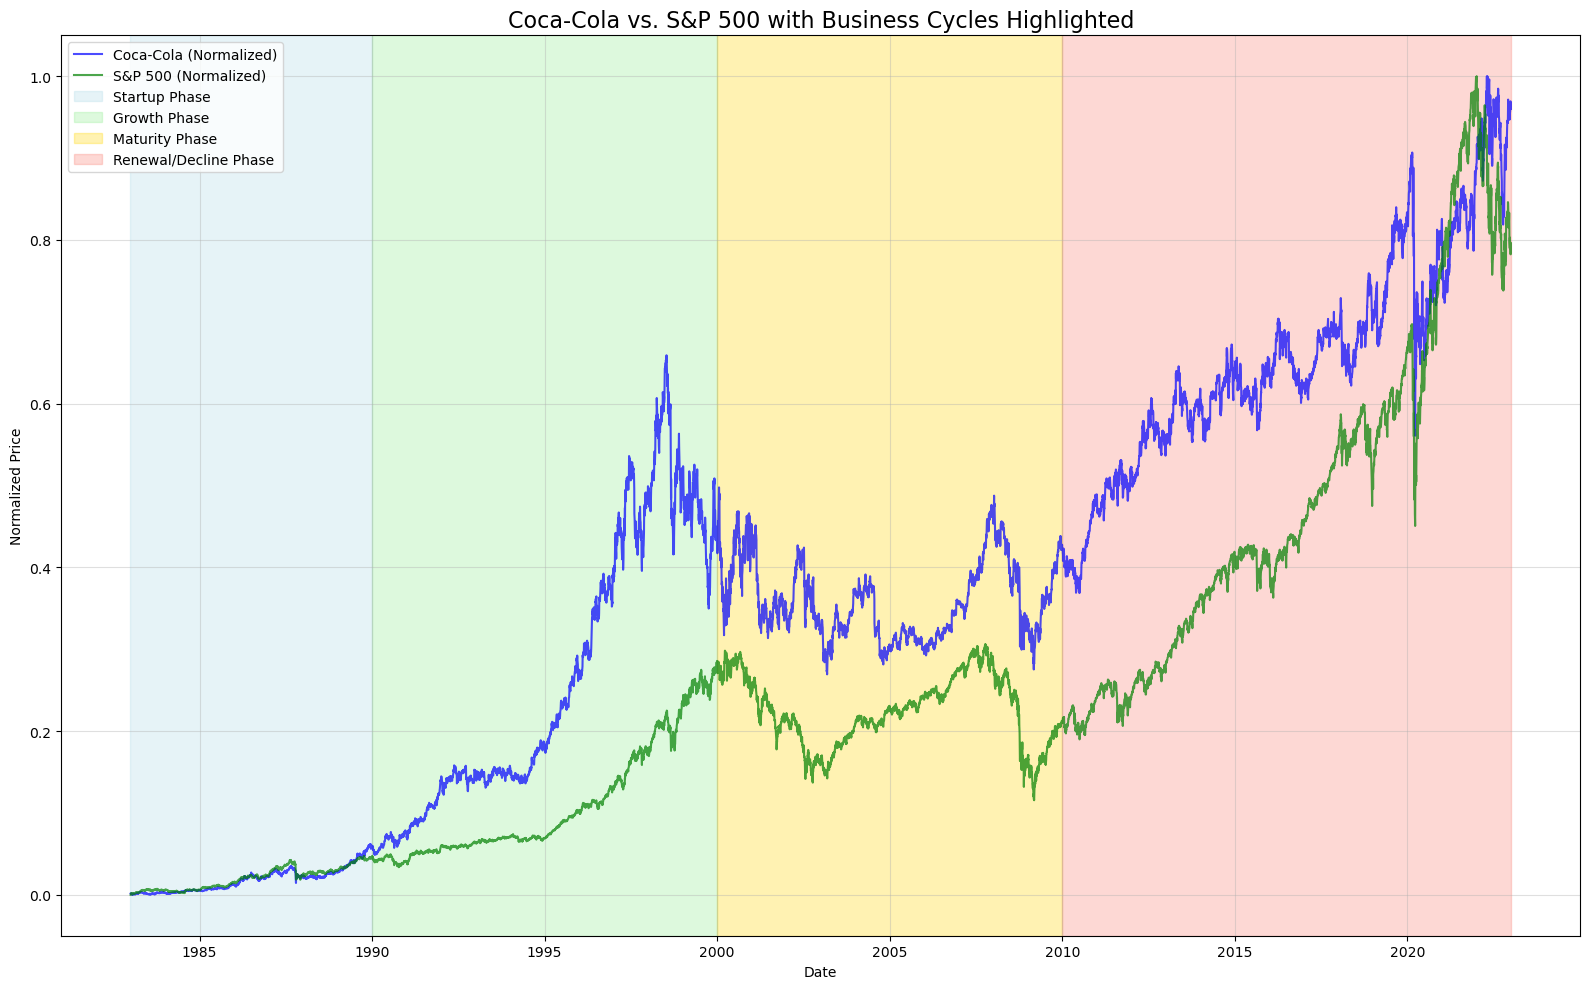

In [19]:
# Define the S&P 500 ticker and download data
SP500_Ticker = '^GSPC'
SP500_Data = yf.download(SP500_Ticker, start=FY2024_START, end=FY2024_END)
df_SP500_close = SP500_Data['Close']

# Normalize both datasets for comparison
df_KO_norm = (df_KO_close - df_KO_close.min()) / (df_KO_close.max() - df_KO_close.min())
df_SP500_norm = (df_SP500_close - df_SP500_close.min()) / (df_SP500_close.max() - df_SP500_close.min())

# Plot Coca-Cola and S&P 500 with business cycle highlights
plt.figure(figsize=(16, 10))

# Plot Coca-Cola normalized data
plt.plot(df_KO_norm, label="Coca-Cola (Normalized)", color="blue", alpha=0.7)

# Plot S&P 500 normalized data
plt.plot(df_SP500_norm, label="S&P 500 (Normalized)", color="green", alpha=0.7)

# Highlight business cycles
plt.axvspan("1983-01-01", "1990-01-01", color="lightblue", alpha=0.3, label="Startup Phase")
plt.axvspan("1990-01-01", "2000-01-01", color="lightgreen", alpha=0.3, label="Growth Phase")
plt.axvspan("2000-01-01", "2010-01-01", color="gold", alpha=0.3, label="Maturity Phase")
plt.axvspan("2010-01-01", "2023-01-01", color="salmon", alpha=0.3, label="Renewal/Decline Phase")

# Title, labels, legend, and grid
plt.title("Coca-Cola vs. S&P 500 with Business Cycles Highlighted", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


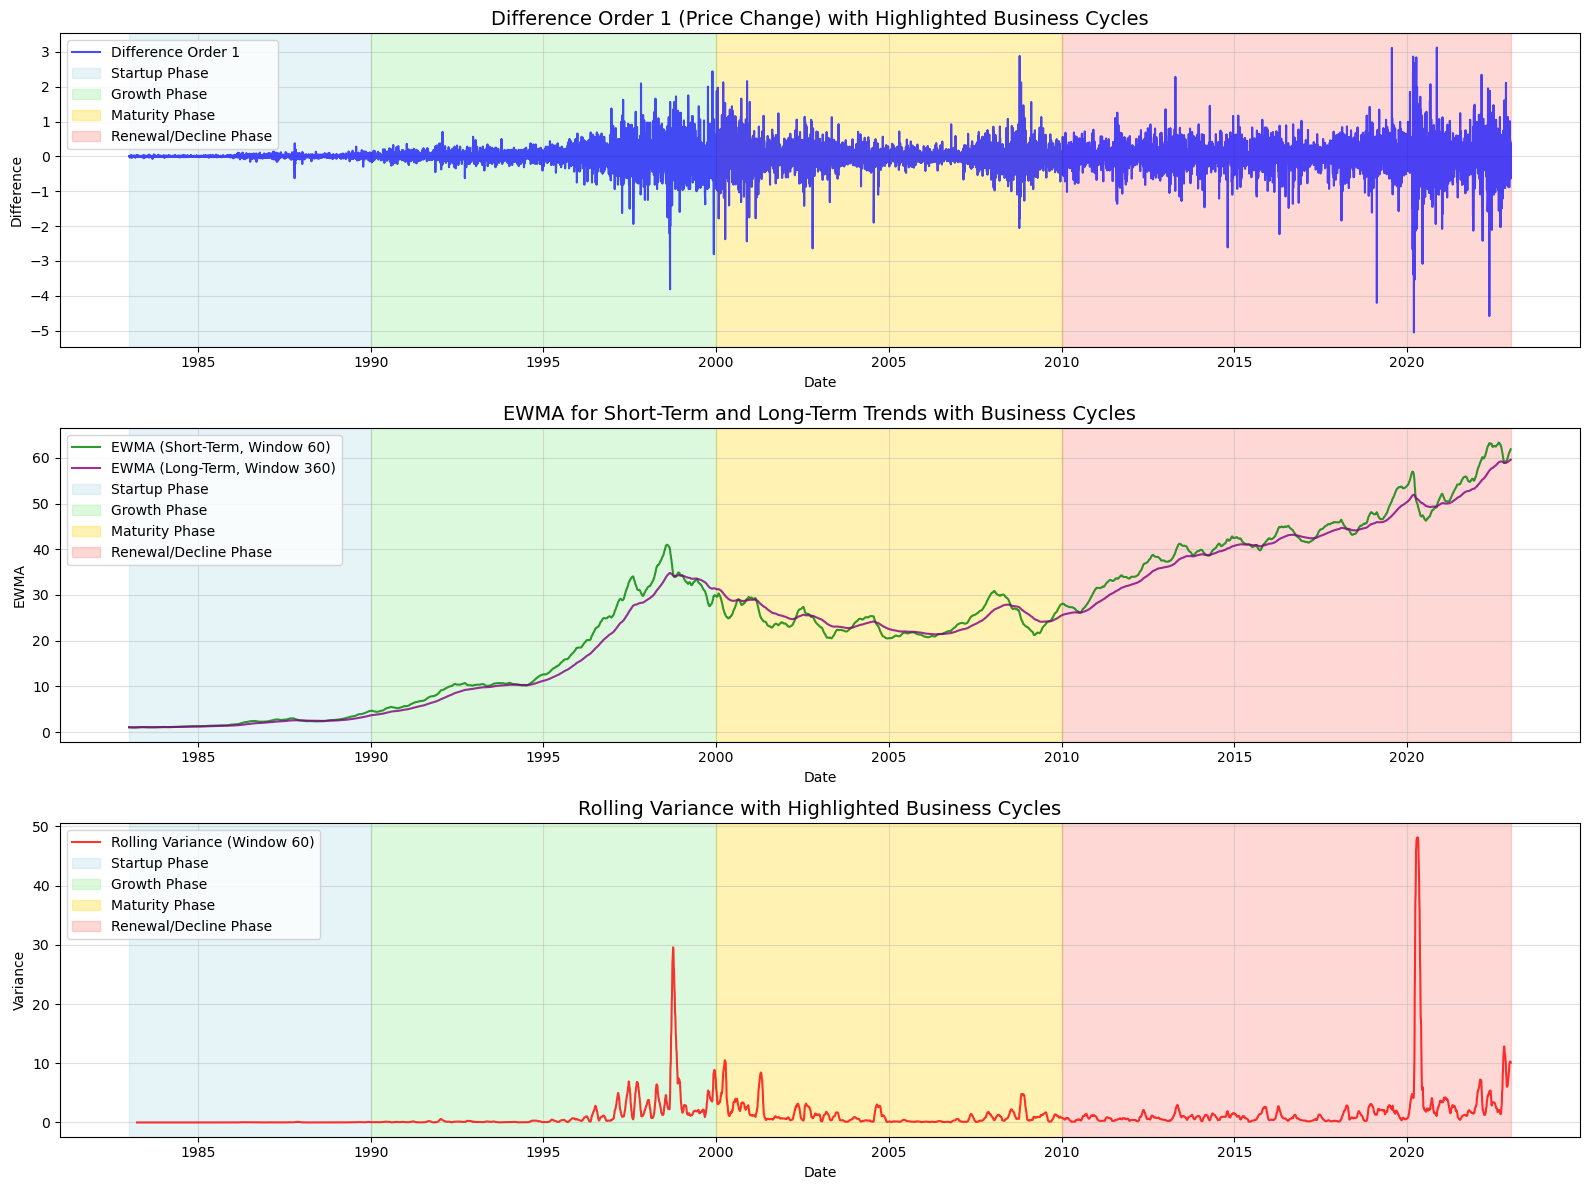

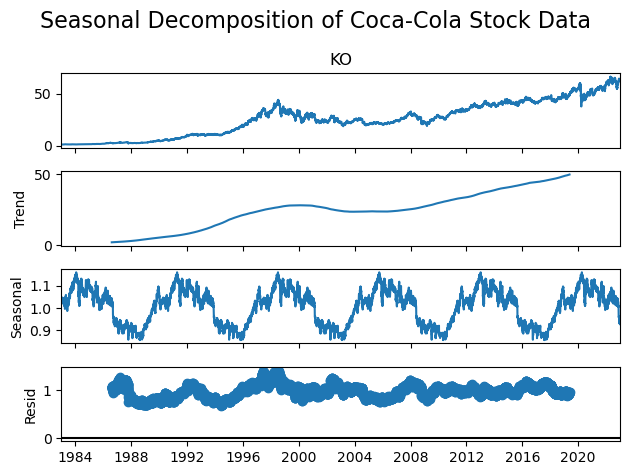

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to calculate rolling variance
def calculate_rolling_variance(series, window):
    """
    Calculates rolling variance for a given series and window size.

    Parameters:
    series (pd.Series): The time series data.
    window (int): The rolling window size.

    Returns:
    pd.Series: The rolling variance series.
    """
    return series.rolling(window=window).var()

# Define rolling window size
rolling_window = 60  # Short-term variance (60 days)

# Calculate rolling variance and first-order differencing
rolling_variance = calculate_rolling_variance(df_KO_close, rolling_window)
difference_order_1 = df_KO_close.diff()  # First-order differencing

# **Seasonality Check**
# Perform decomposition to analyze seasonal, trend, and residual components
seasonal_decompose_result = seasonal_decompose(df_KO_close, model='multiplicative', period=5*365)  # Annual seasonality (365 days)

# Plot: Difference Order 1, EWMA, and Rolling Variance with Highlighted Business Cycles
plt.figure(figsize=(16, 12))

# Subplot 1: Difference Order 1
plt.subplot(3, 1, 1)
plt.plot(difference_order_1, label="Difference Order 1", color="blue", alpha=0.7)

# Highlight business cycles with color-coded segments
# Startup Phase: Stability, little market movement
plt.axvspan("1983-01-01", "1990-01-01", color="lightblue", alpha=0.3, label="Startup Phase")

# Growth Phase: Rapid expansion, significant upward trend
# Seasonality is less noticeable during this phase, as the trend dominates
plt.axvspan("1990-01-01", "2000-01-01", color="lightgreen", alpha=0.3, label="Growth Phase")

# Maturity Phase: Stabilization of market share; seasonality becomes more evident
plt.axvspan("2000-01-01", "2010-01-01", color="gold", alpha=0.3, label="Maturity Phase")

# Renewal/Decline Phase: Market adaptations and significant volatility
# Dramatic spikes/declines; seasonality can remain strong
plt.axvspan("2010-01-01", "2023-01-01", color="salmon", alpha=0.3, label="Renewal/Decline Phase")

plt.title("Difference Order 1 (Price Change) with Highlighted Business Cycles", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Difference")
plt.legend()
plt.grid(alpha=0.4)

# Subplot 2: EWMA for context
plt.subplot(3, 1, 2)
plt.plot(ewma_short, label="EWMA (Short-Term, Window 60)", color="green", alpha=0.8)
plt.plot(ewma_long, label="EWMA (Long-Term, Window 360)", color="purple", alpha=0.8)
plt.axvspan("1983-01-01", "1990-01-01", color="lightblue", alpha=0.3, label="Startup Phase")
plt.axvspan("1990-01-01", "2000-01-01", color="lightgreen", alpha=0.3, label="Growth Phase")
plt.axvspan("2000-01-01", "2010-01-01", color="gold", alpha=0.3, label="Maturity Phase")
plt.axvspan("2010-01-01", "2023-01-01", color="salmon", alpha=0.3, label="Renewal/Decline Phase")
plt.title("EWMA for Short-Term and Long-Term Trends with Business Cycles", fontsize=14)
plt.xlabel("Date")
plt.ylabel("EWMA")
plt.legend()
plt.grid(alpha=0.4)

# Subplot 3: Rolling Variance
plt.subplot(3, 1, 3)
plt.plot(rolling_variance, label="Rolling Variance (Window 60)", color="red", alpha=0.8)
plt.axvspan("1983-01-01", "1990-01-01", color="lightblue", alpha=0.3, label="Startup Phase")
plt.axvspan("1990-01-01", "2000-01-01", color="lightgreen", alpha=0.3, label="Growth Phase")
plt.axvspan("2000-01-01", "2010-01-01", color="gold", alpha=0.3, label="Maturity Phase")
plt.axvspan("2010-01-01", "2023-01-01", color="salmon", alpha=0.3, label="Renewal/Decline Phase")
plt.title("Rolling Variance with Highlighted Business Cycles", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

# Plot the decomposition to check for seasonality
seasonal_decompose_result.plot()
plt.suptitle("Seasonal Decomposition of Coca-Cola Stock Data", fontsize=16)
plt.tight_layout()
plt.show()


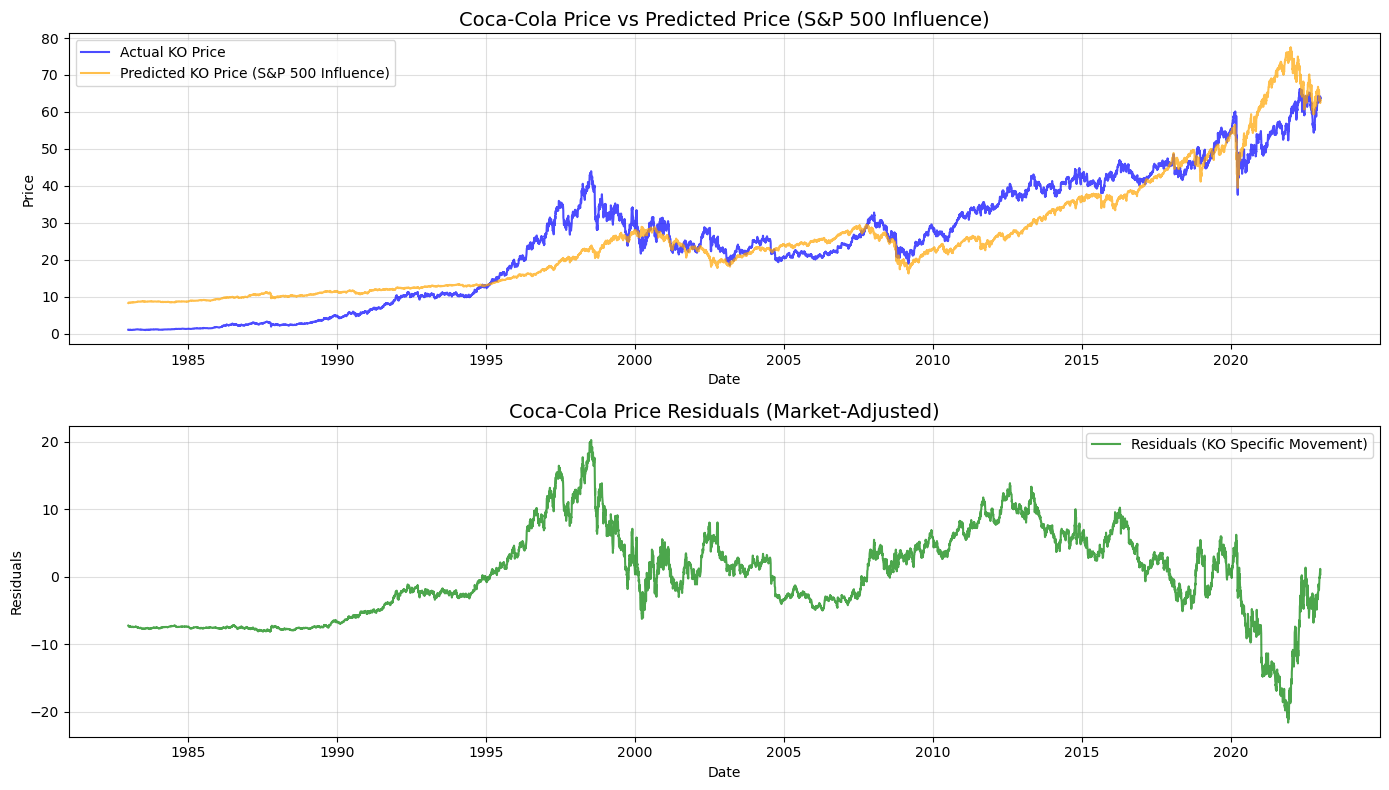

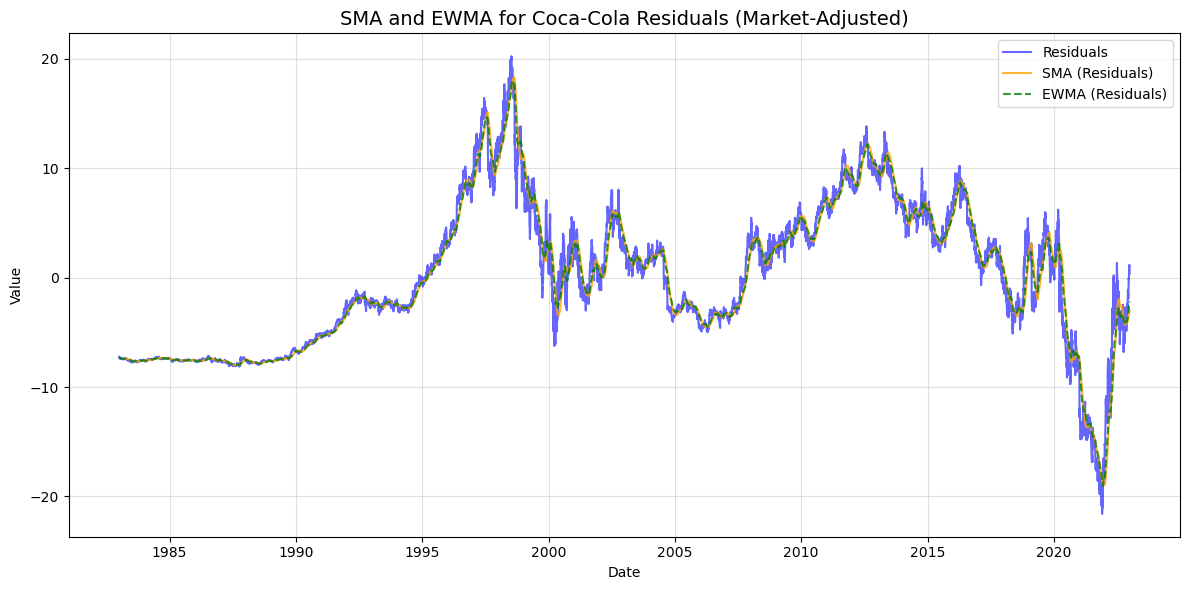

Variance of Coca-Cola Residuals (Market-Adjusted): 43.87


In [21]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Align both datasets by index
df_combined = pd.concat([df_KO_close, df_SP500_close], axis=1, join="inner")
df_combined.columns = ["KO_Close", "SP500_Close"]

# Remove rows with NaN values
df_combined.dropna(inplace=True)

# Extract variables
X = df_combined["SP500_Close"].values.reshape(-1, 1)  # Independent variable
y = df_combined["KO_Close"].values  # Dependent variable

# Linear Regression to model Coca-Cola's price as a function of the S&P 500
model = LinearRegression()
model.fit(X, y)

# Predict Coca-Cola's price based on S&P 500
y_pred = model.predict(X)

# Calculate residuals (Coca-Cola-specific price movement)
residuals = y - y_pred

# Add residuals to the dataframe for analysis
df_combined["Residuals"] = residuals

# Calculate variance of residuals
residual_variance = residuals.var()

# Plot residuals, Coca-Cola price, and predicted Coca-Cola price
plt.figure(figsize=(14, 8))

# Subplot 1: Coca-Cola and Predicted Prices
plt.subplot(2, 1, 1)
plt.plot(df_combined.index, df_combined["KO_Close"], label="Actual KO Price", color="blue", alpha=0.7)
plt.plot(df_combined.index, y_pred, label="Predicted KO Price (S&P 500 Influence)", color="orange", alpha=0.7)
plt.title("Coca-Cola Price vs Predicted Price (S&P 500 Influence)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.4)

# Subplot 2: Residuals
plt.subplot(2, 1, 2)
plt.plot(df_combined.index, residuals, label="Residuals (KO Specific Movement)", color="green", alpha=0.7)
plt.title("Coca-Cola Price Residuals (Market-Adjusted)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

# Calculate SMA and EWMA on residuals
sma_residuals = pd.Series(residuals).rolling(window=short_term_window).mean()
ewma_residuals = pd.Series(residuals).ewm(span=short_term_window).mean()

# Plot SMA and EWMA for residuals
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, residuals, label="Residuals", color="blue", alpha=0.6)
plt.plot(df_combined.index, sma_residuals, label="SMA (Residuals)", color="orange", alpha=0.8)
plt.plot(df_combined.index, ewma_residuals, label="EWMA (Residuals)", color="green", linestyle="--", alpha=0.8)
plt.title("SMA and EWMA for Coca-Cola Residuals (Market-Adjusted)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Print the variance of residuals
print(f"Variance of Coca-Cola Residuals (Market-Adjusted): {residual_variance:.2f}")


# ACF PACF TESTING

In [22]:
##############
# Augmented Dickey-Fuller Test
#
# Ho: It is non-stationary
# H1: It is stationary
#
#####

def adfuller_test(sales):
    result=adfuller(sales)
    print(result)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [23]:
#applying the test on our closed prices to confirm non-stationarity

test_result=adfuller_test(df_KO_close)
test_result

(-0.1655170347527108, 0.9425090142205351, 36, 10047, {'1%': -3.4310010372782322, '5%': -2.8618277198980784, '10%': -2.5669231481622323}, 9902.785703309575)
ADF Test Statistic : -0.1655170347527108
p-value : 0.9425090142205351
#Lags Used : 36
Number of Observations : 10047
weak evidence against null hypothesis,indicating it is non-stationary 


In [24]:
#a function that determines the differencing order required to make time series stationary utilizing the ADF test
#Parameters: df_data -> time series data to analyze.  Returns: diff_order (int)


def find_adf_diff_order(df_data):
   
    
    diff_order = 0
    while True:
        # Apply the ADF test to the current series
        result = adfuller(df_data.dropna())
        labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']
        
        print(f"\nADF Test Results for Differencing Order {diff_order}:")
        for value, label in zip(result, labels):
            print(f"{label}: {value}")

        # Check the p-value to decide stationarity
        if result[1] <= 0.05:
            print("Strong evidence against the null hypothesis (H0), data is stationary.")
            break
        else:
            print("Weak evidence against the null hypothesis, data is non-stationary.")
            diff_order += 1
            df_data = df_data.diff()  # Apply differencing for the next order
    
    return diff_order


In [25]:
#running diff test on the KO data to find the appropriate differencing order 
find_adf_diff_order(df_KO_close)


ADF Test Results for Differencing Order 0:
ADF Test Statistic: -0.1655170347527108
p-value: 0.9425090142205351
#Lags Used: 36
Number of Observations: 10047
Weak evidence against the null hypothesis, data is non-stationary.

ADF Test Results for Differencing Order 1:
ADF Test Statistic: -17.925669642073533
p-value: 2.895426171892038e-30
#Lags Used: 35
Number of Observations: 10047
Strong evidence against the null hypothesis (H0), data is stationary.


1

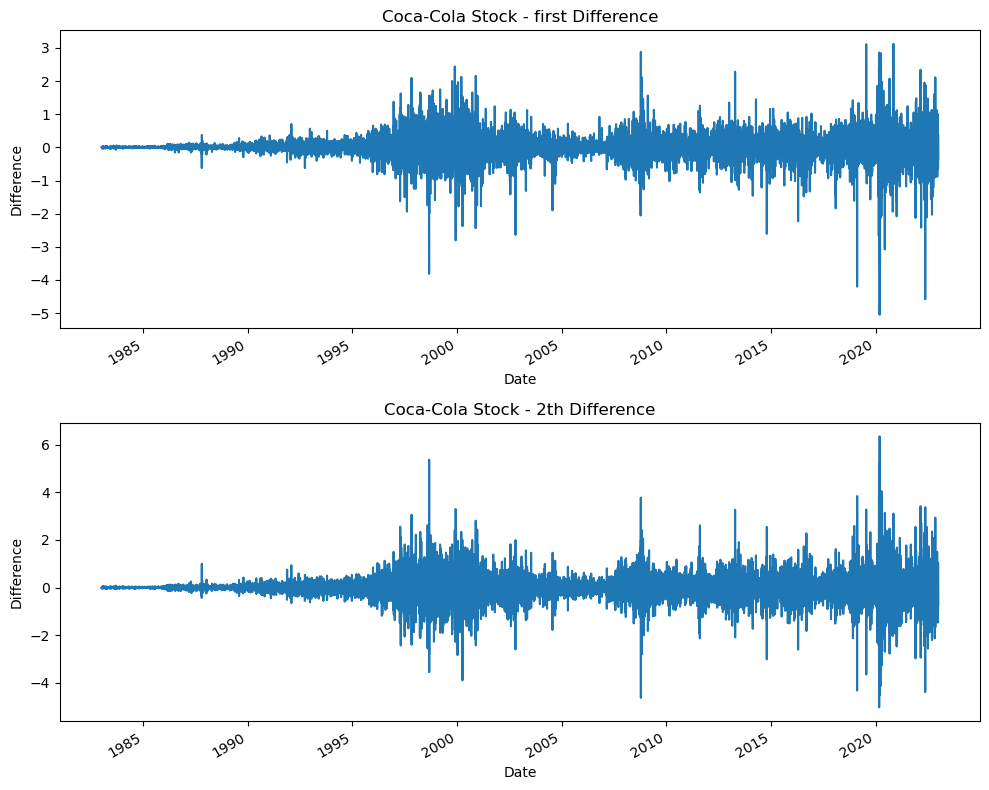

In [26]:
#To confirm the differencing order

# First Difference Plot
plt.figure(figsize=(10, 8))  # Adjusting figure size for better visualization
plt.subplot(2, 1, 1)  # Using 2 rows and 1 column to plot side by side
df_KO_close.diff().plot()
plt.title('Coca-Cola Stock - first Difference')
plt.xlabel('Date')
plt.ylabel('Difference')

# Higher-Order Differencing
# Removes deeper trends or persistent patterns over time. 
DIFF_ORDER = 2
df_diff = df_KO_close.copy()

# Apply differencing iteratively
for _ in range(DIFF_ORDER):
    df_diff = df_diff.diff()

plt.subplot(2, 1, 2)
df_diff.plot()
plt.title(f'Coca-Cola Stock - {DIFF_ORDER}th Difference')
plt.xlabel('Date')
plt.ylabel('Difference')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [27]:
#KO data with differencing order of 1 

df_KO_Sta_Close = df_KO_close.diff().dropna()

In [28]:
#testing for stationarity 

test_result=adfuller_test(df_KO_Sta_Close)
test_result

(-17.925669642073533, 2.895426171892038e-30, 35, 10047, {'1%': -3.4310010372782322, '5%': -2.8618277198980784, '10%': -2.5669231481622323}, 9900.834726524037)
ADF Test Statistic : -17.925669642073533
p-value : 2.895426171892038e-30
#Lags Used : 35
Number of Observations : 10047
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Figure size 3000x1000 with 0 Axes>

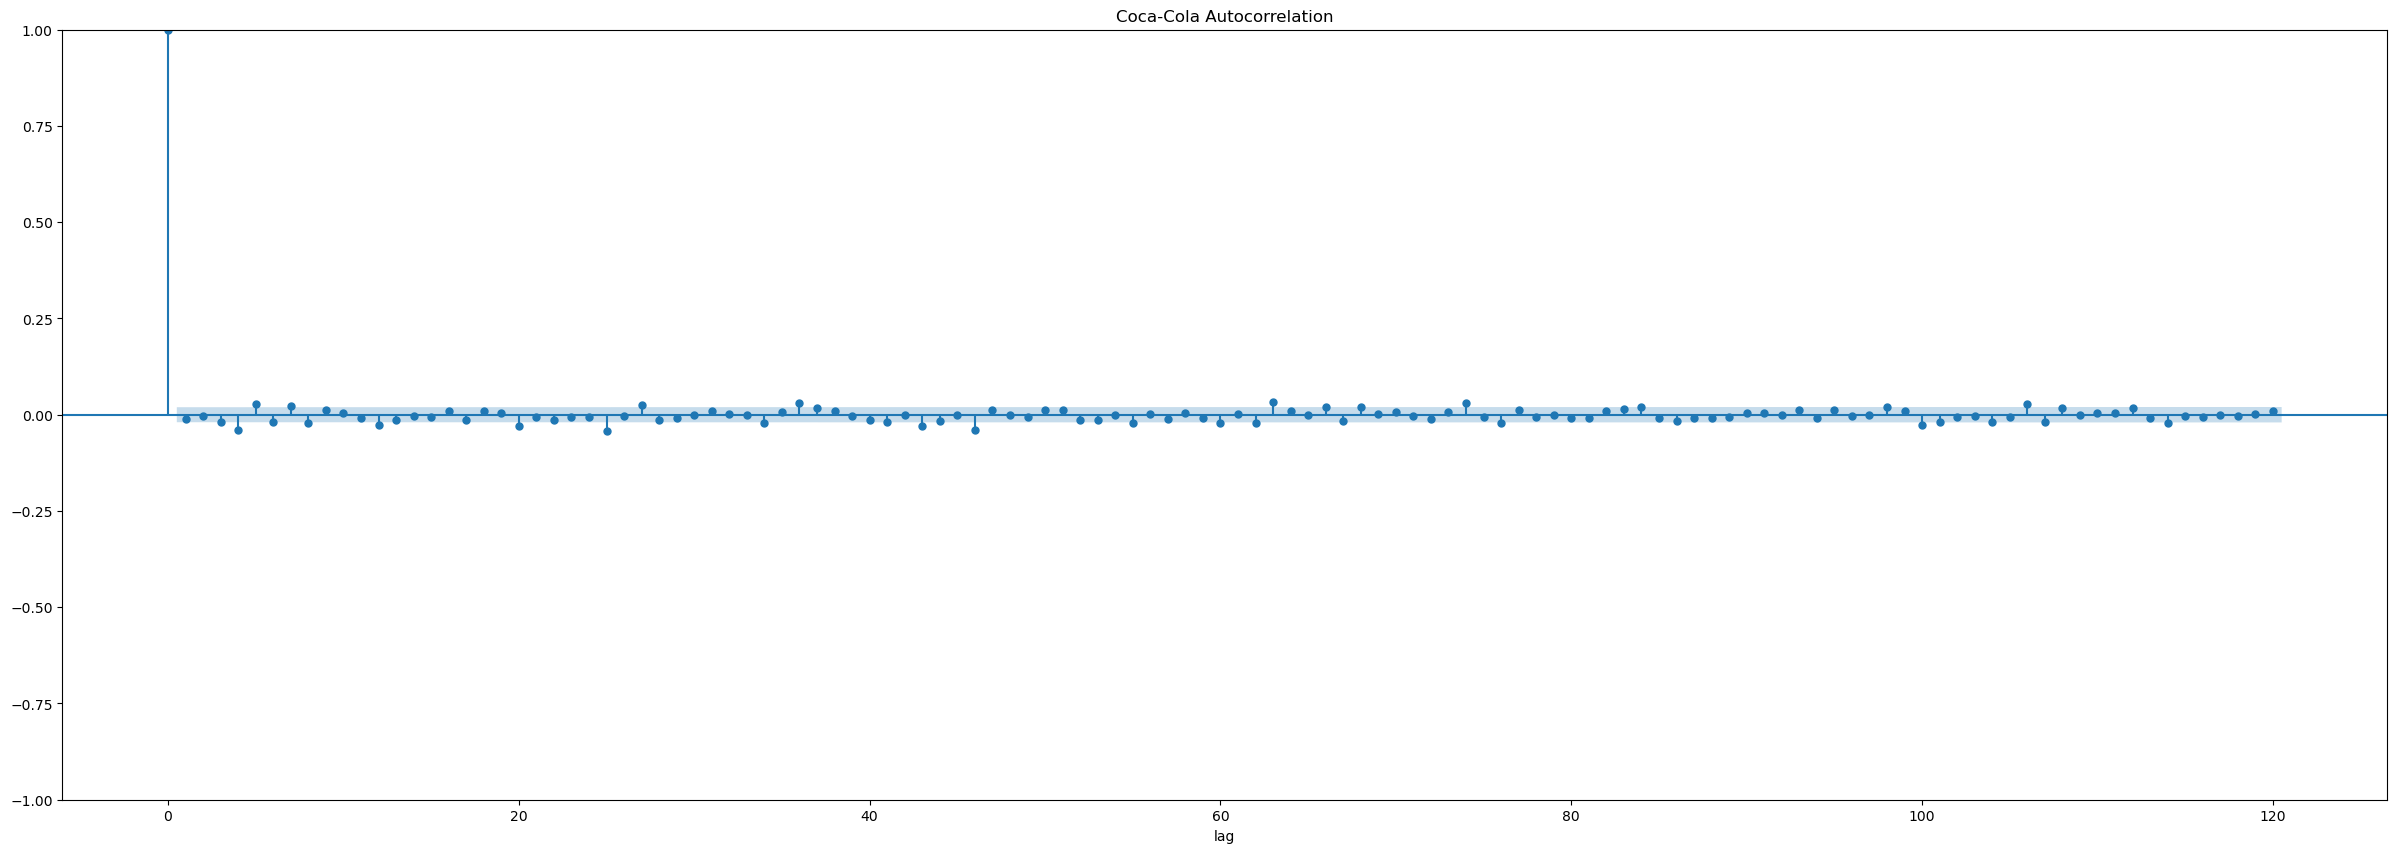

In [29]:
# ACF for stationary data
plt.figure(5,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_KO_Sta_Close, lags= 120, title='Coca-Cola Autocorrelation',alpha=0.05,ax=ax);

<Figure size 3000x1000 with 0 Axes>

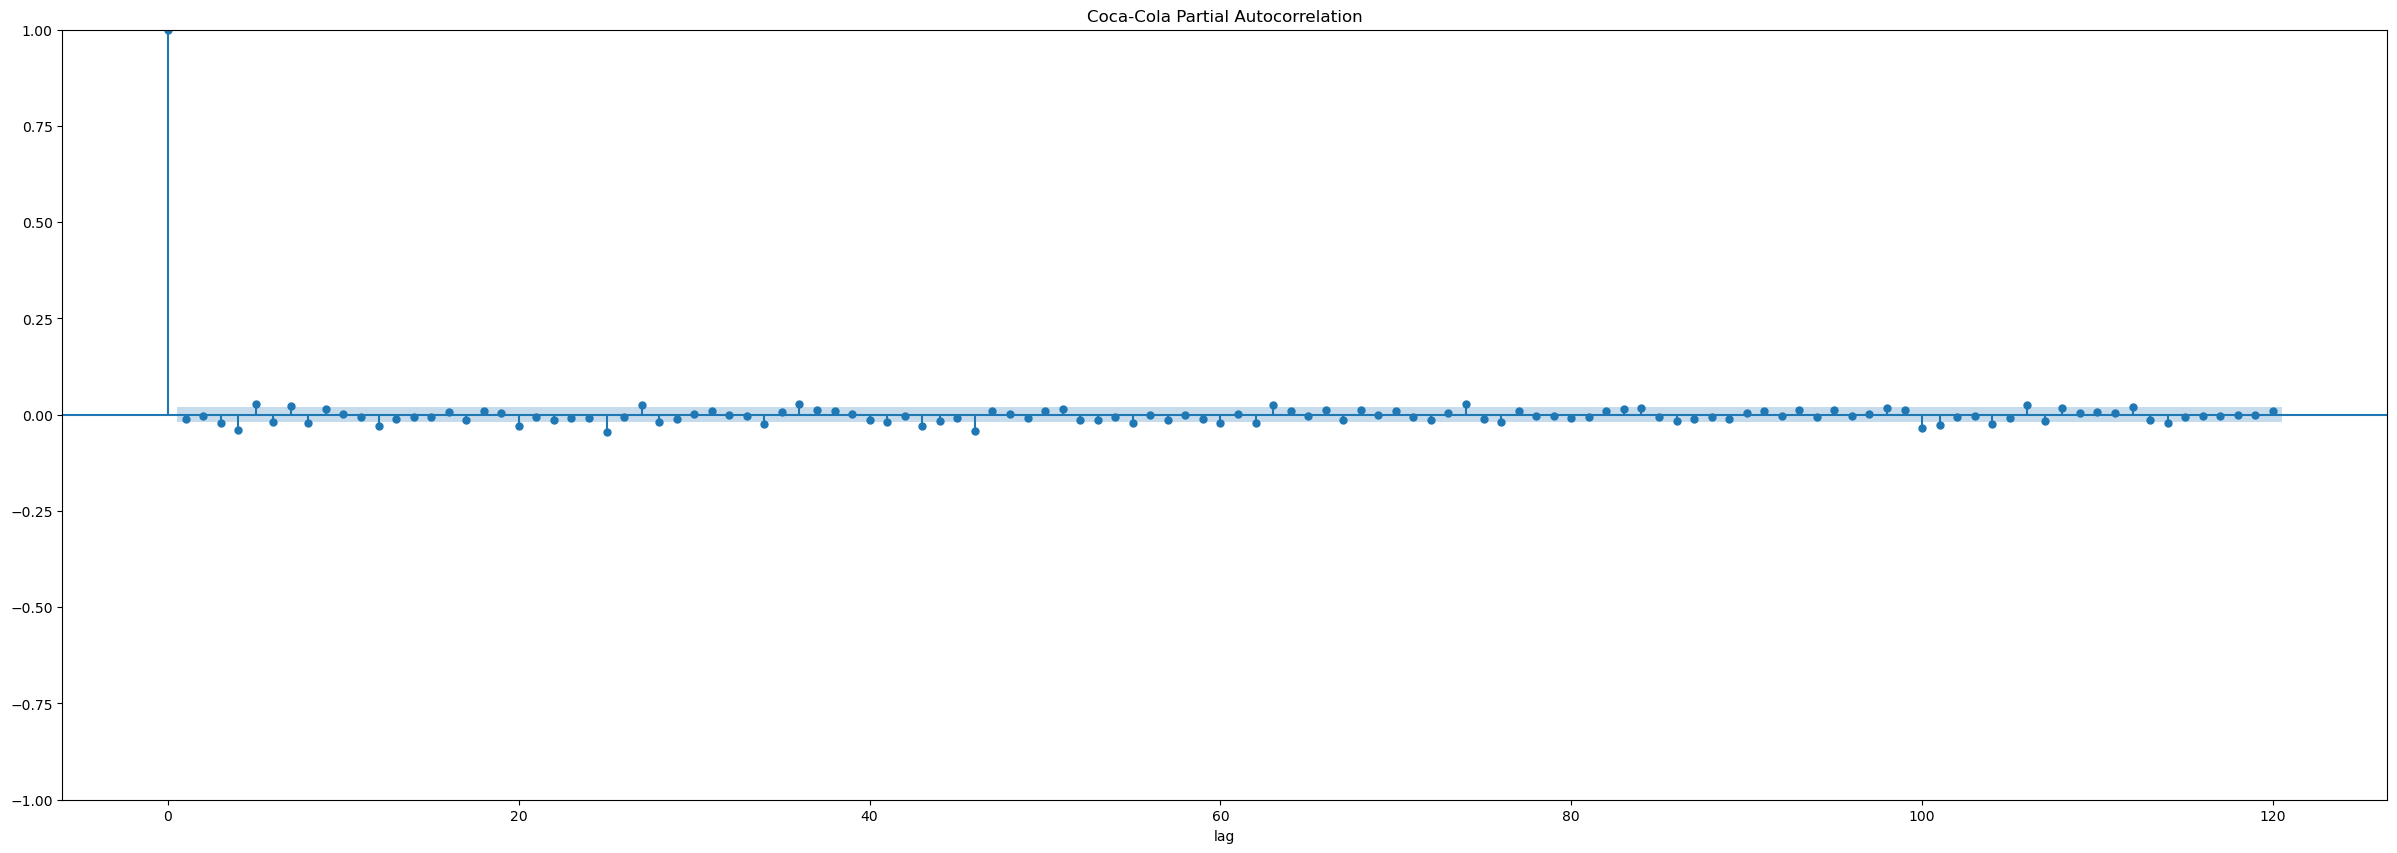

In [30]:
# PACF on stationary data
plt.figure(4,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_KO_Sta_Close, lags=120 , title='Coca-Cola Partial Autocorrelation',alpha=0.05,ax=ax);

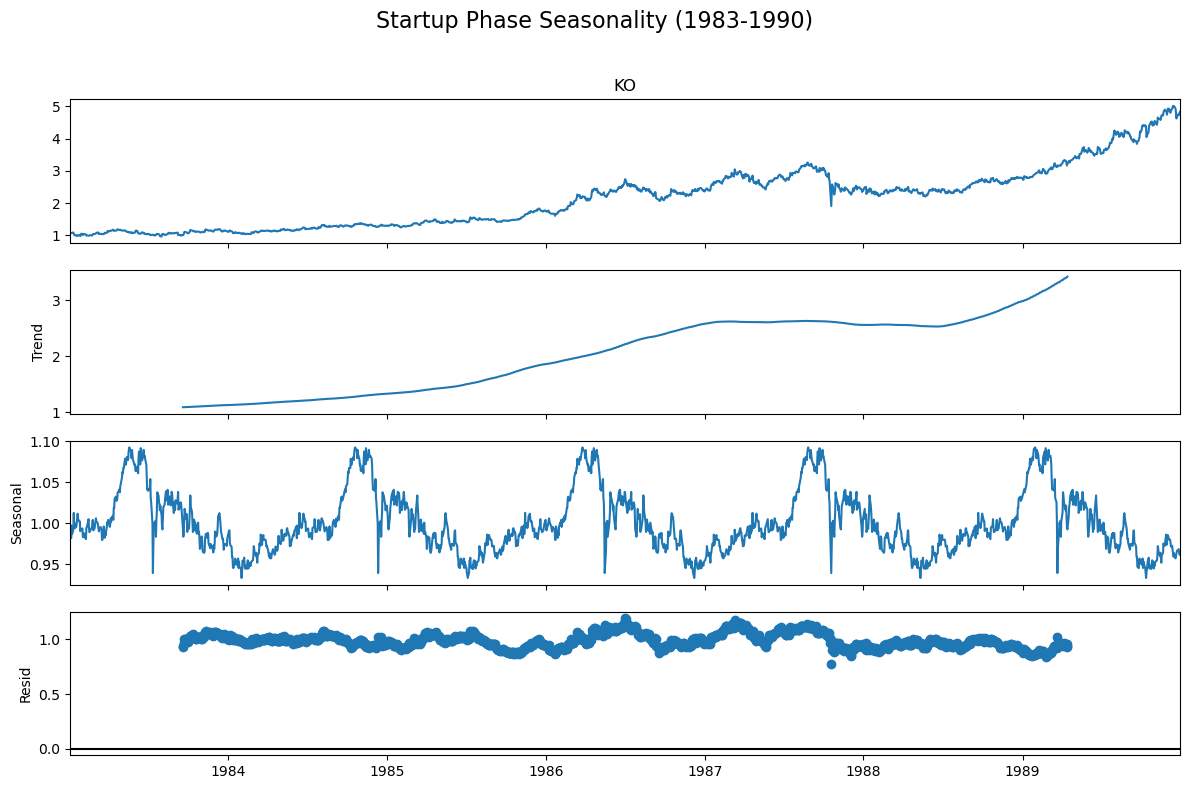

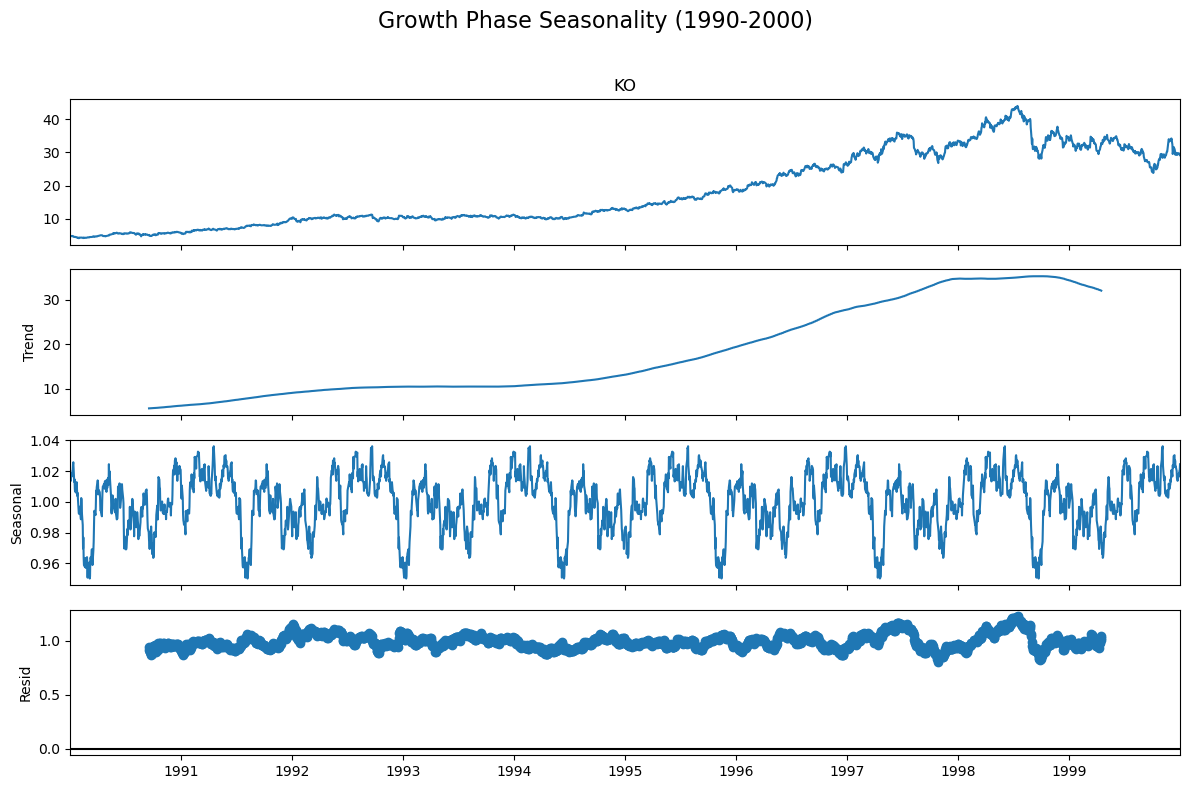

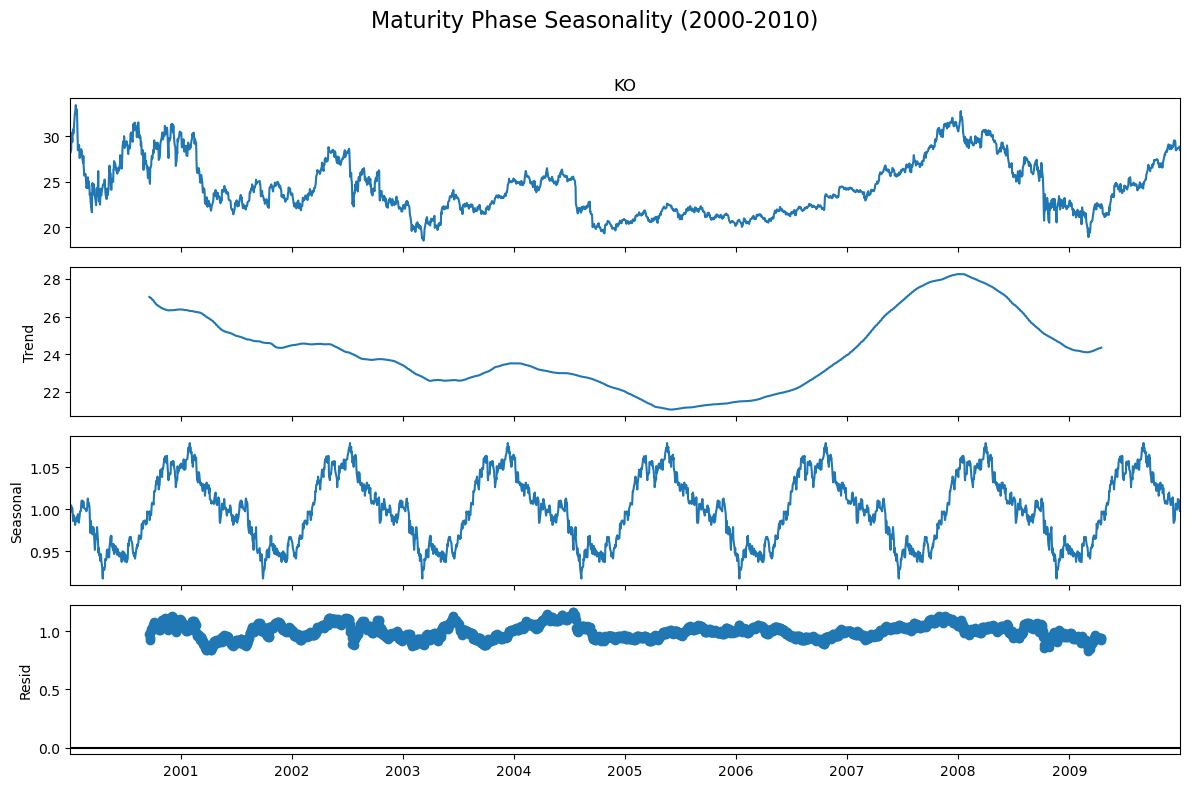

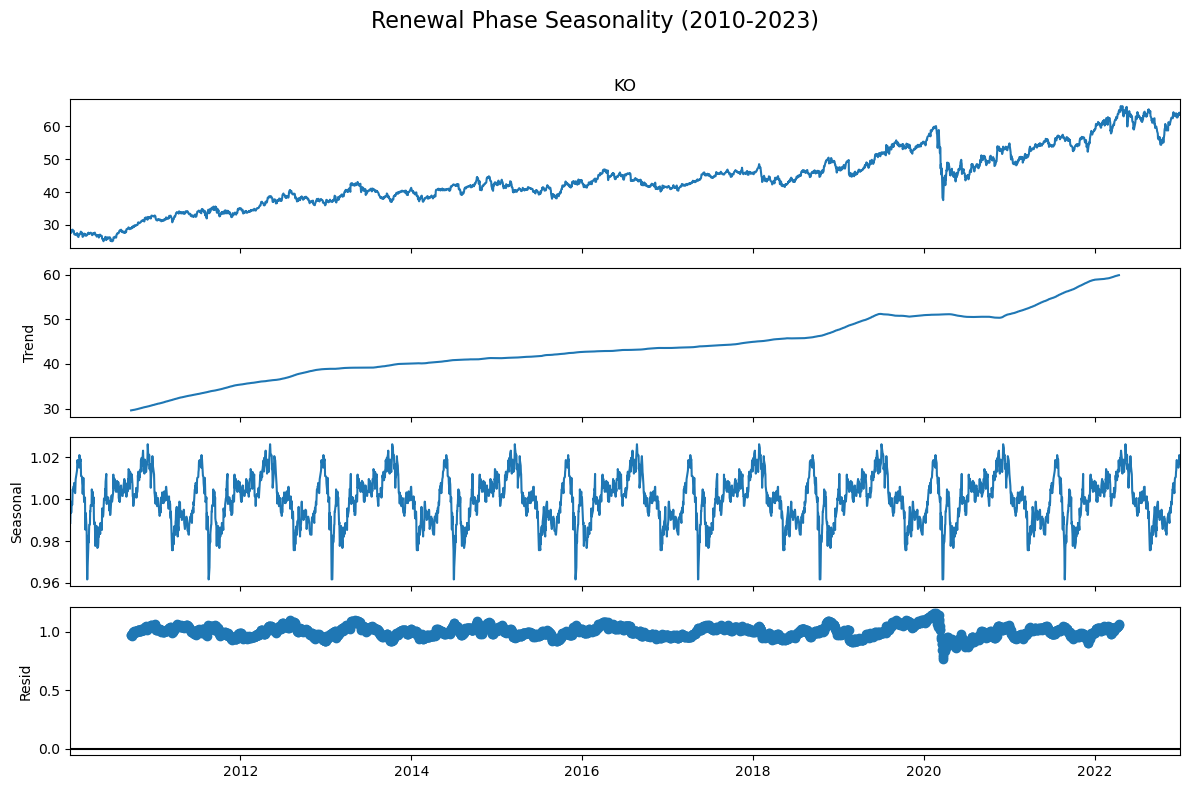

In [31]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
 
# Split the data into the defined business cycles
startup_phase = df_KO_close.loc["1983-01-01":"1990-01-01"]
growth_phase = df_KO_close.loc["1990-01-01":"2000-01-01"]
maturity_phase = df_KO_close.loc["2000-01-01":"2010-01-01"]
renewal_phase = df_KO_close.loc["2010-01-01":"2023-01-01"]
 
# Define function to decompose and plot seasonal components for each phase
def plot_seasonality(data, title, period):
    decomposition = seasonal_decompose(data, model='multiplicative', period=period)
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
 
# Define the period (360 days per quarter)
DAYS_PER_QUARTER = 360
 
# Generate seasonal decomposition plots for each phase
plot_seasonality(startup_phase, "Startup Phase Seasonality (1983-1990)", DAYS_PER_QUARTER)
plot_seasonality(growth_phase, "Growth Phase Seasonality (1990-2000)", DAYS_PER_QUARTER)
plot_seasonality(maturity_phase, "Maturity Phase Seasonality (2000-2010)", DAYS_PER_QUARTER)
plot_seasonality(renewal_phase, "Renewal Phase Seasonality (2010-2023)", DAYS_PER_QUARTER)

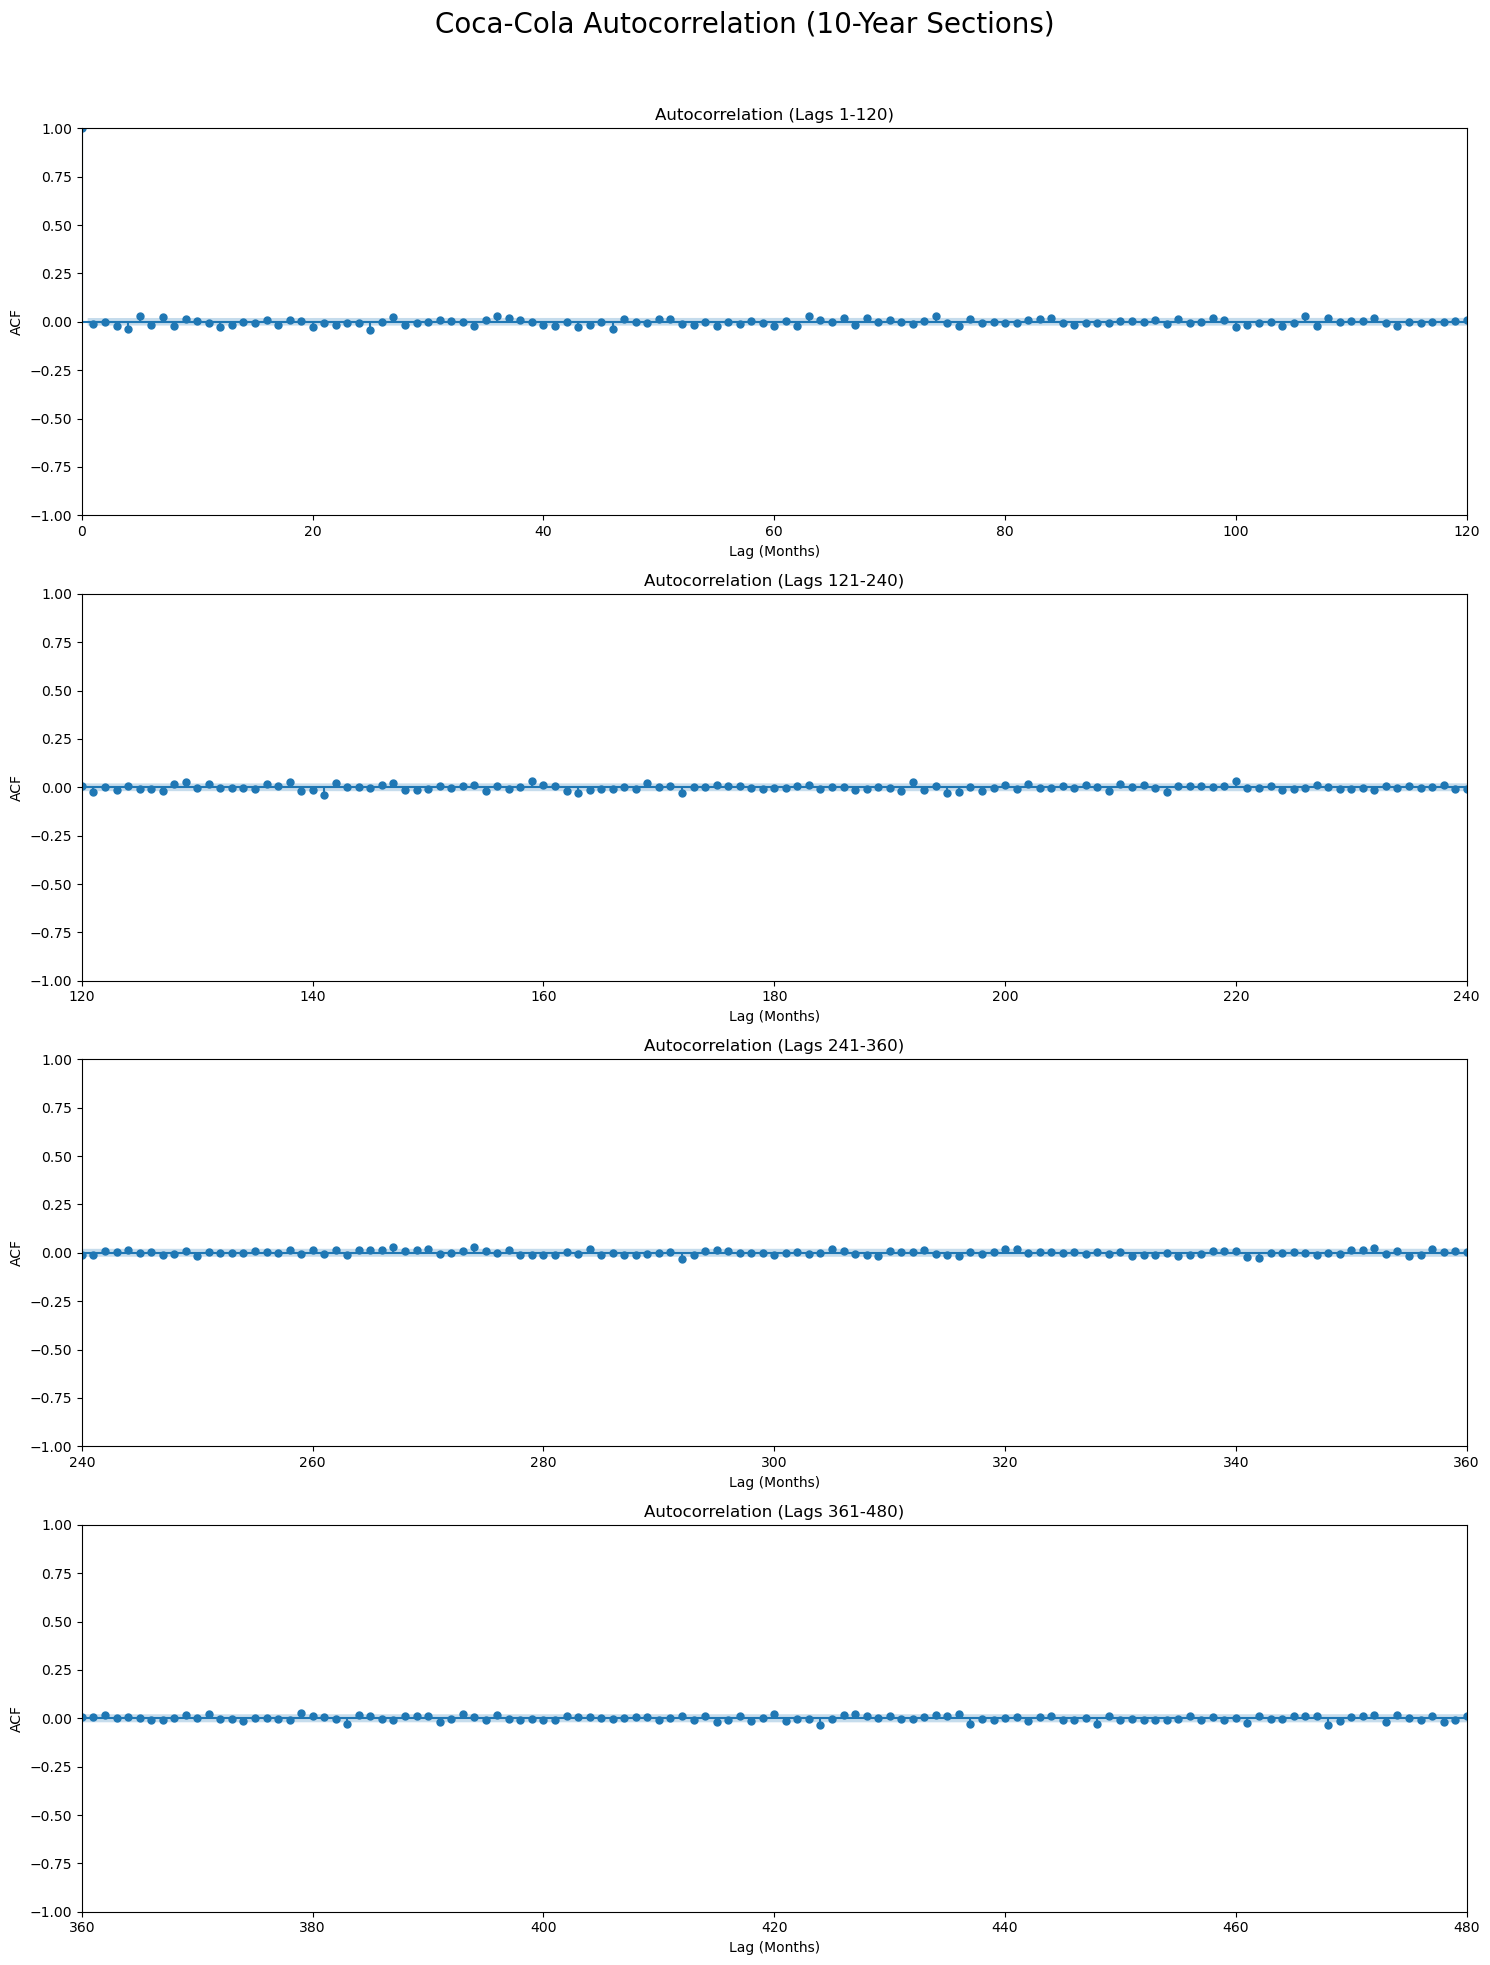

In [32]:
# Define lags for 10 years (120 months = 10 years × 12 months)
lags_per_section = 120  # 10 years of monthly data
total_lags = 480  # 40 years of monthly data

# Number of sections (40 years split into 10-year intervals)
num_sections = total_lags // lags_per_section

# Create subplots for each 10-year section
fig, axs = plt.subplots(nrows=num_sections, figsize=(15, 20))
fig.suptitle("Coca-Cola Autocorrelation (10-Year Sections)", fontsize=20)

for i, ax in enumerate(axs):
    start_lag = i * lags_per_section
    end_lag = start_lag + lags_per_section

    # Plot ACF for each 10-year section
    plot_acf(
        df_KO_Sta_Close, 
        lags=end_lag, 
        title=f"Autocorrelation (Lags {start_lag + 1}-{end_lag})", 
        alpha=0.05, 
        ax=ax
    )
    ax.set_xlim([start_lag, end_lag])
    ax.set_xlabel("Lag (Months)")
    ax.set_ylabel("ACF")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# MODELING


In [33]:
#adjusted parameters for the ARIMA model

order = (25, 1, 25)  # From the ACF and PACF plots

model_2 = ARIMA(df_KO_close , order = order)

result_2 = model_2.fit() 
result_2.summary() 

C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     KO   No. Observations:                10084
Model:               ARIMA(25, 1, 25)   Log Likelihood               -4905.728
Date:                Tue, 17 Dec 2024   AIC                           9913.456
Time:                        23:04:55   BIC                          10281.605
Sample:                             0   HQIC                         10038.021
                              - 10084                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2031      0.268     -0.759      0.448      -0.728       0.322
ar.L2         -0.2729      0.239     -1.141      0.254      -0.742       0.196
ar.L3         -0.0340      0.288     -0.118      0.906      -0.598       0.530
ar.L4         -0.0139      0.226     -0.062      0.951      -0.457       0.430
ar.L5          0.0288      0.196      0.147      0.883      -0.354       0.412
ar.L6          0.0577      0.163      0.354      0.723      -0.262       0.377
ar.L7          0.0526      0.150      0.350      0.727      -0.242       0.347
ar.L8          0.0816      0.143      0.572      0.567      -0.198       0.361
ar.L9          0.2207      0.136      1.619      0.106      -0.047       0.488
ar.L10        -0.0325      0.149     -0.219      0.827      -0.324       0.259
ar.L11        -0.1077      0.147     -0.731      0.465      -0.396       0.181
ar.L12        -0.1587      0.136     -1.164      0.245      -0.426       0.109
ar.L13        -0.1623      0.154     -1.055      0.291      -0.464       0.139
ar.L14        -0.0315      0.143     -0.220      0.826      -0.313       0.250
ar.L15        -0.0236      0.144     -0.164      0.870      -0.306       0.258
ar.L16         0.0679      0.135      0.503      0.615      -0.197       0.333
ar.L17         0.1003      0.125      0.802      0.423      -0.145       0.345
ar.L18         0.2890      0.126      2.293      0.022       0.042       0.536
ar.L19         0.0789      0.092      0.857      0.392      -0.102       0.259
ar.L20         0.3960      0.105      3.760      0.000       0.190       0.602
ar.L21         0.3351      0.139      2.413      0.016       0.063       0.607
ar.L22         0.1613      0.178      0.904      0.366      -0.188       0.511
ar.L23        -0.1395      0.183     -0.764      0.445      -0.497       0.218
ar.L24        -0.0907      0.162     -0.559      0.576      -0.409       0.227
ar.L25        -0.1551      0.124     -1.251      0.211      -0.398       0.088
ma.L1          0.1981      0.268      0.738      0.460      -0.328       0.724
ma.L2          0.2683      0.240      1.120      0.263      -0.201       0.738
ma.L3          0.0118      0.287      0.041      0.967      -0.551       0.575
ma.L4         -0.0344      0.225     -0.153      0.878      -0.476       0.407
ma.L5         -0.0242      0.187     -0.129      0.897      -0.390       0.342
ma.L6         -0.0954      0.155     -0.615      0.539      -0.399       0.209
ma.L7         -0.0382      0.143     -0.267      0.790      -0.318       0.242
ma.L8         -0.1141      0.139     -0.822      0.411      -0.386       0.158
ma.L9         -0.2090      0.137     -1.526      0.127      -0.477       0.059
ma.L10         0.0421      0.145      0.290      0.772      -0.242       0.327
ma.L11         0.1167      0.144      0.812      0.417      -0.165       0.399
ma.L12         0.1490      0.132      1.129      0.259      -0.110       0.408
ma.L13         0.1501      0.147      1.019      0.308      -0.139       0.439
ma

In [34]:
#######
# New index from Date Time
#
# Utility routine to fix issue with yfinance DateTime index
###
def computeDateList(startDate, numDays):
    dateList = []
    for x in range (0, numDays):
        dt= startDate + datetime.timedelta(days= x)
    
        dateList.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
        
    return dateList

In [35]:
#Define start dartes for both historical and forecasting data

origStartDate= datetime.datetime(1981, 1 ,1)

forecastStartDate= datetime.datetime(2023,1,1)

#total number of of days in the historical data
HIST_DAYS= df_KO_close.size

#number of days to forecast
NUM_DAYS= 1825

#Generate datetime indices for historical and forecast data
KODateIndex= computeDateList(origStartDate,HIST_DAYS)

forecastDateIndex= computeDateList(forecastStartDate, NUM_DAYS)


C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0.5, 1.0, 'ARIMA forecast horizon= 1825 steps')

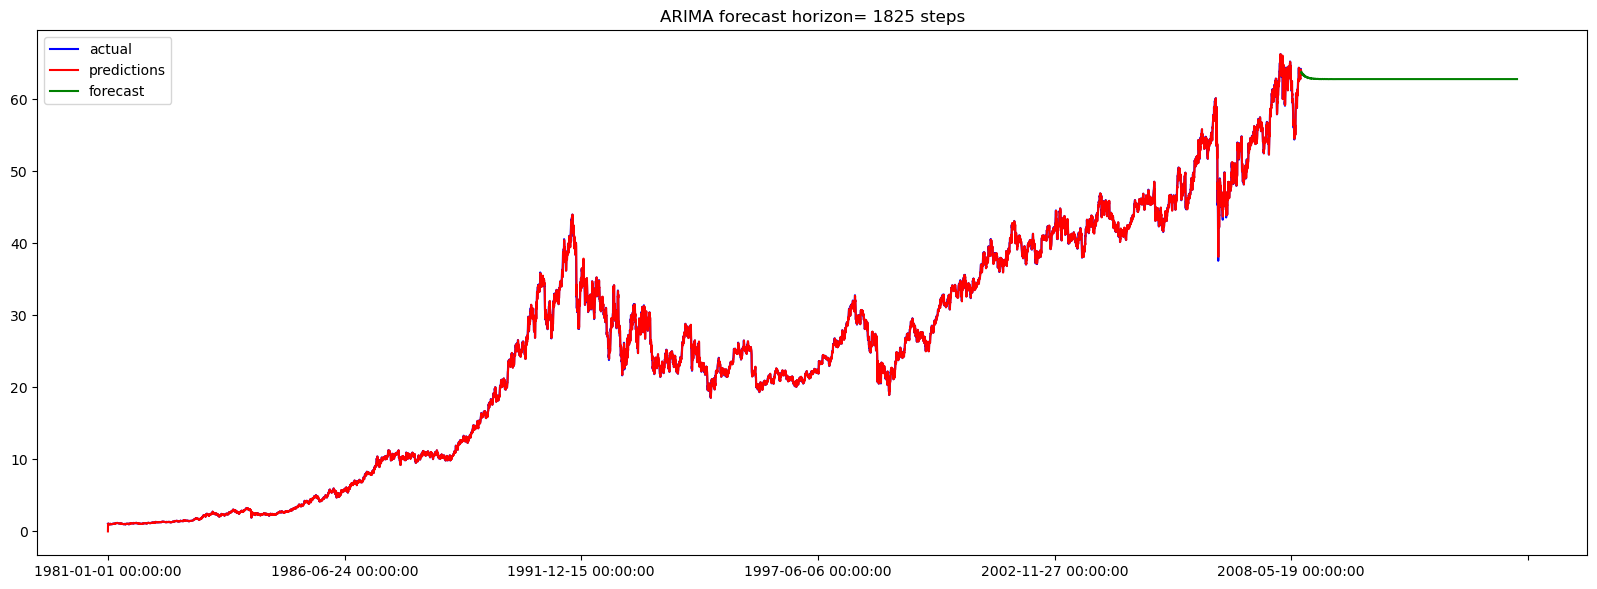

In [36]:
####
# do the forecast over time horizon (future days)
##
forecast= result_2.forecast(steps=NUM_DAYS)

myForecast_2= pd.Series(forecast.values, index=forecastDateIndex)

####
# do prediction over existing time series
##
predictions= result_2.predict()

####
# set Series index to proper datetime formatted strings
##
myPredictions_2= pd.Series(predictions.values, index= KODateIndex)

myKOClose= pd.Series(df_KO_close.values, index= KODateIndex)

####
# Visualize
###
plt.figure(12,figsize=(20,15))
plt.subplot(2,1,1)
myKOClose.plot(color='blue',label='actual')
myPredictions_2.plot(color='red',label='predictions')
forecast.plot(color='green',label='forecast')
plt.legend()
plt.title(f'ARIMA forecast horizon= {NUM_DAYS} steps')

In [37]:
# Historical Coca-Cola data (e.g., from df_KO_close)
historical_prices = df_KO_close

# Step 1: Calculate historical daily returns
daily_returns = historical_prices.pct_change().dropna()  # Percentage change
historical_volatility = daily_returns.std()  # Standard deviation of daily returns

# Step 2: Generate random noise
np.random.seed(42)  # For reproducibility
noise = np.random.normal(loc=0.0, scale=historical_volatility, size=len(myForecast_2))

# Scale the noise by the forecasted values
scaled_noise = noise * myForecast_2.values

# Step 3: Add noise to the forecast
noisy_forecast = myForecast_2 + scaled_noise

# Convert to a pandas Series
noisy_forecast_series = pd.Series(noisy_forecast.values, index=myForecast_2.index)


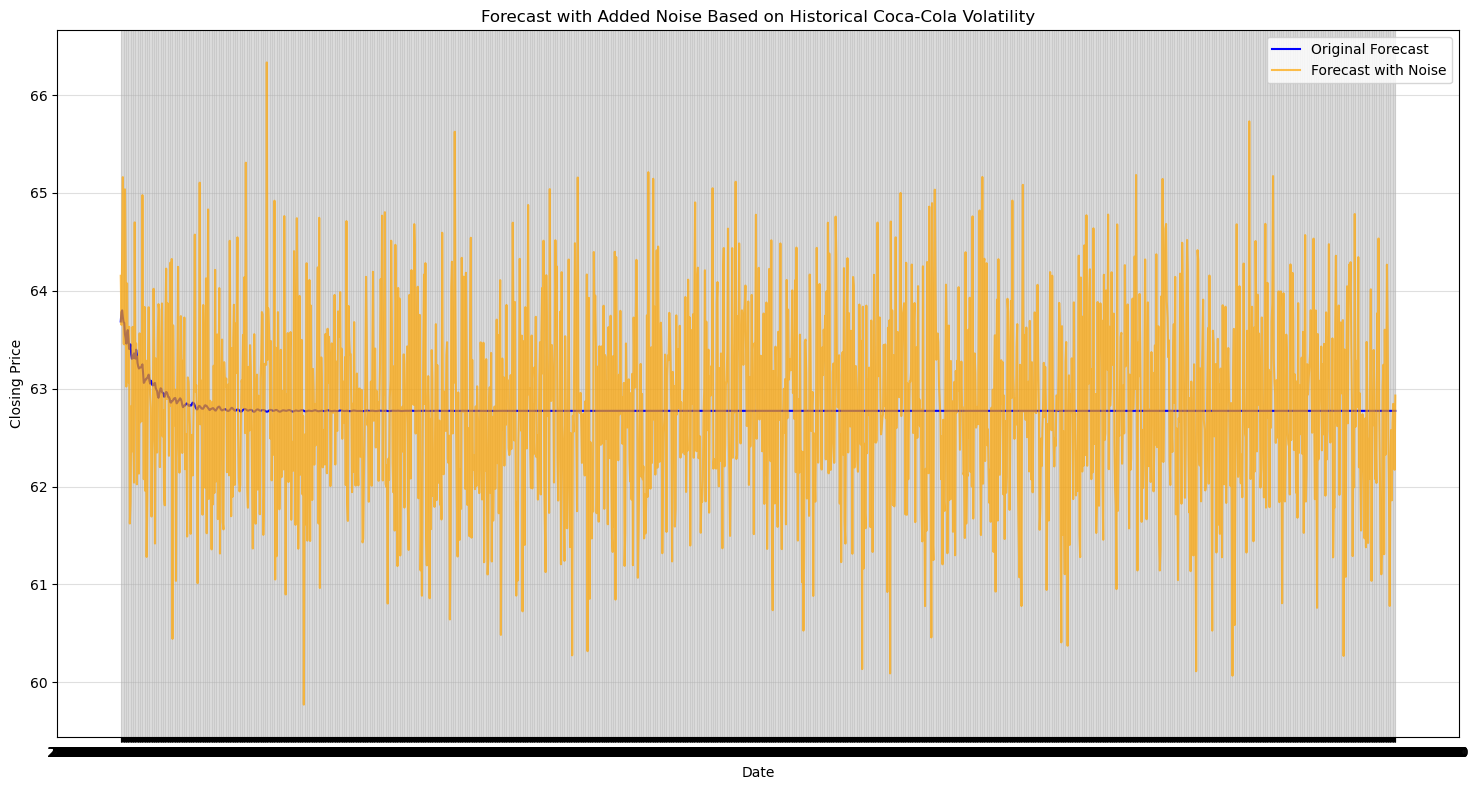

In [38]:
#plots the original forecast + forecast with noise

plt.figure(figsize=(15, 8))
plt.plot(myForecast_2, label="Original Forecast", color="blue")
plt.plot(noisy_forecast_series, label="Forecast with Noise", color="orange", alpha=0.7)
plt.title("Forecast with Added Noise Based on Historical Coca-Cola Volatility")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


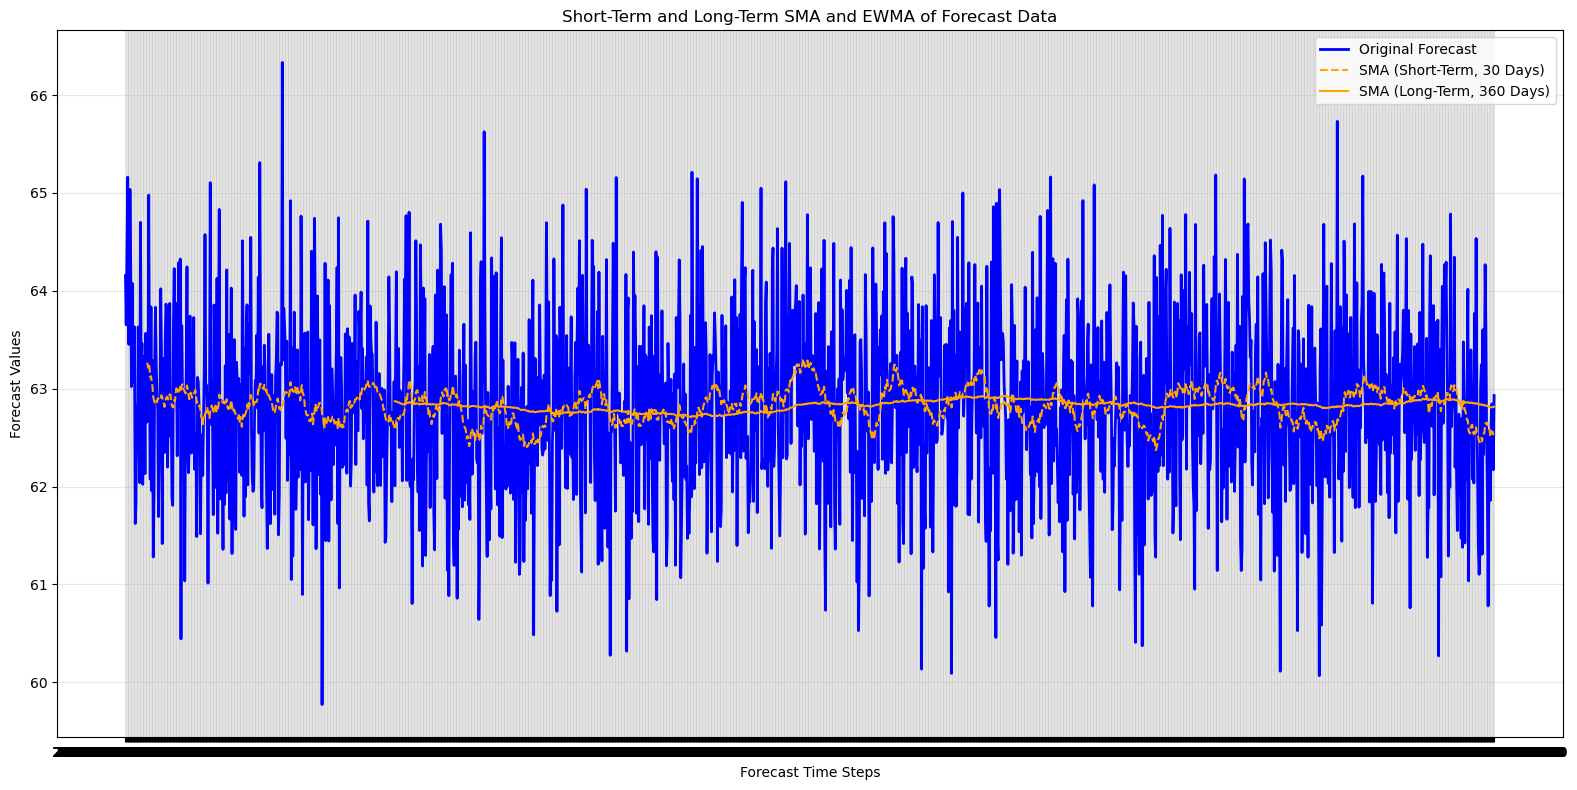

In [39]:
# Define window sizes
SHORT_TERM_WINDOW = 30    # Short-term window (e.g., ~1 month)
LONG_TERM_WINDOW = 360     # Long-term window (e.g., ~3 months)

# Calculate SMA (Simple Moving Average) for the forecast
sma_short_forecast = noisy_forecast_series.rolling(window=SHORT_TERM_WINDOW).mean()
sma_long_forecast = noisy_forecast_series.rolling(window=LONG_TERM_WINDOW).mean()

# Calculate EWMA (Exponentially Weighted Moving Average) for the forecast
ewma_short_forecast = noisy_forecast_series.ewm(span=SHORT_TERM_WINDOW, adjust=False).mean()
ewma_long_forecast = noisy_forecast_series.ewm(span=LONG_TERM_WINDOW, adjust=False).mean()

# Plot the original forecast with SMA and EWMA
plt.figure(figsize=(16, 8))

# Plot the original forecast
plt.plot(noisy_forecast_series, color='blue', label='Original Forecast', linewidth=2)

# Plot Short-Term SMA and EWMA
plt.plot(sma_short_forecast, color='orange', linestyle='--', label=f'SMA (Short-Term, {SHORT_TERM_WINDOW} Days)')
#plt.plot(ewma_short_forecast, color='purple', linestyle='--', label=f'EWMA (Short-Term, {SHORT_TERM_WINDOW} Days)')

# Plot Long-Term SMA and EWMA
plt.plot(sma_long_forecast, color='orange', linestyle='-', label=f'SMA (Long-Term, {LONG_TERM_WINDOW} Days)')
#plt.plot(ewma_long_forecast, color='purple', linestyle='-', label=f'EWMA (Long-Term, {LONG_TERM_WINDOW} Days)')

# Add title and labels
plt.title('Short-Term and Long-Term SMA and EWMA of Forecast Data')
plt.xlabel('Forecast Time Steps')
plt.ylabel('Forecast Values')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


In [40]:
#Define start dartes for both historical and forecasting data

#total number of of days in the historical data
HIST_DAYS= renewal_phase.size

#number of days to forecast
NUM_DAYS= 1825

#Generate datetime indices for historical and forecast data
KODateIndex= computeDateList(origStartDate,HIST_DAYS)

forecastDateIndex= computeDateList(forecastStartDate, NUM_DAYS)


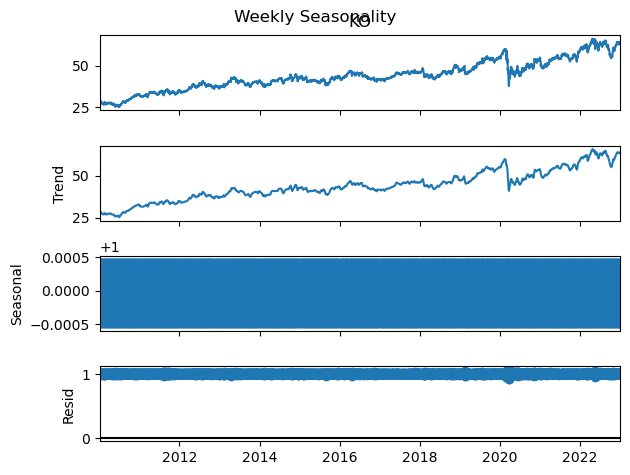

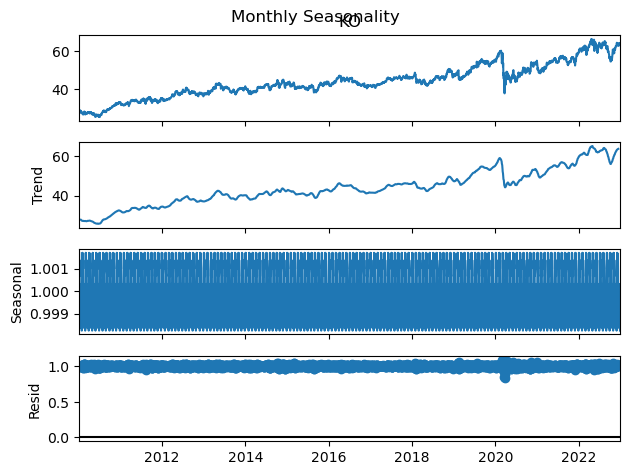

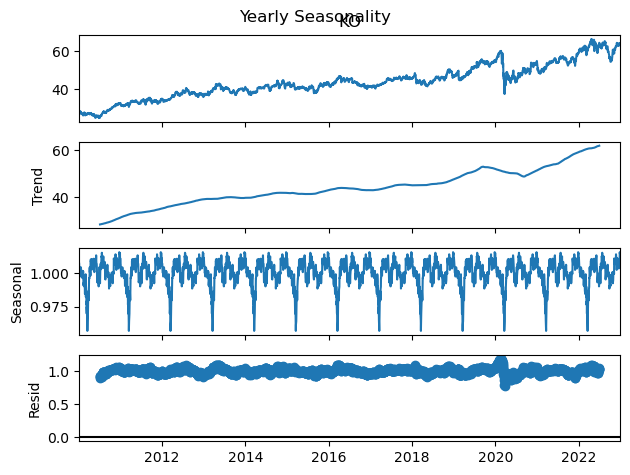

In [42]:

# Decompose for Weekly Seasonality (7 days)
result_weekly = seasonal_decompose(renewal_phase, model='multiplicative', period=7)
result_weekly.plot()
plt.suptitle("Weekly Seasonality")
plt.show()

# Decompose for Monthly Seasonality (21 days)
result_monthly = seasonal_decompose(renewal_phase, model='multiplicative', period=21)
result_monthly.plot()
plt.suptitle("Monthly Seasonality")
plt.show()

# Decompose for Yearly Seasonality (252 days)
result_yearly = seasonal_decompose(renewal_phase, model='multiplicative', period=252)
result_yearly.plot()
plt.suptitle("Yearly Seasonality")
plt.show()


In [43]:
#renewal phase KO data with differencing order of 1 

df_KO_Sta_Close2 = renewal_phase.diff().dropna()

In [44]:
#testing for stationarity for renewal stationary data

test_result=adfuller_test(df_KO_Sta_Close2)
test_result

(-12.608463103255913, 1.6755726281454165e-23, 28, 3242, {'1%': -3.43236865676297, '5%': -2.8624319215895935, '10%': -2.567244789154987}, 4834.048227572503)
ADF Test Statistic : -12.608463103255913
p-value : 1.6755726281454165e-23
#Lags Used : 28
Number of Observations : 3242
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Figure size 3000x1000 with 0 Axes>

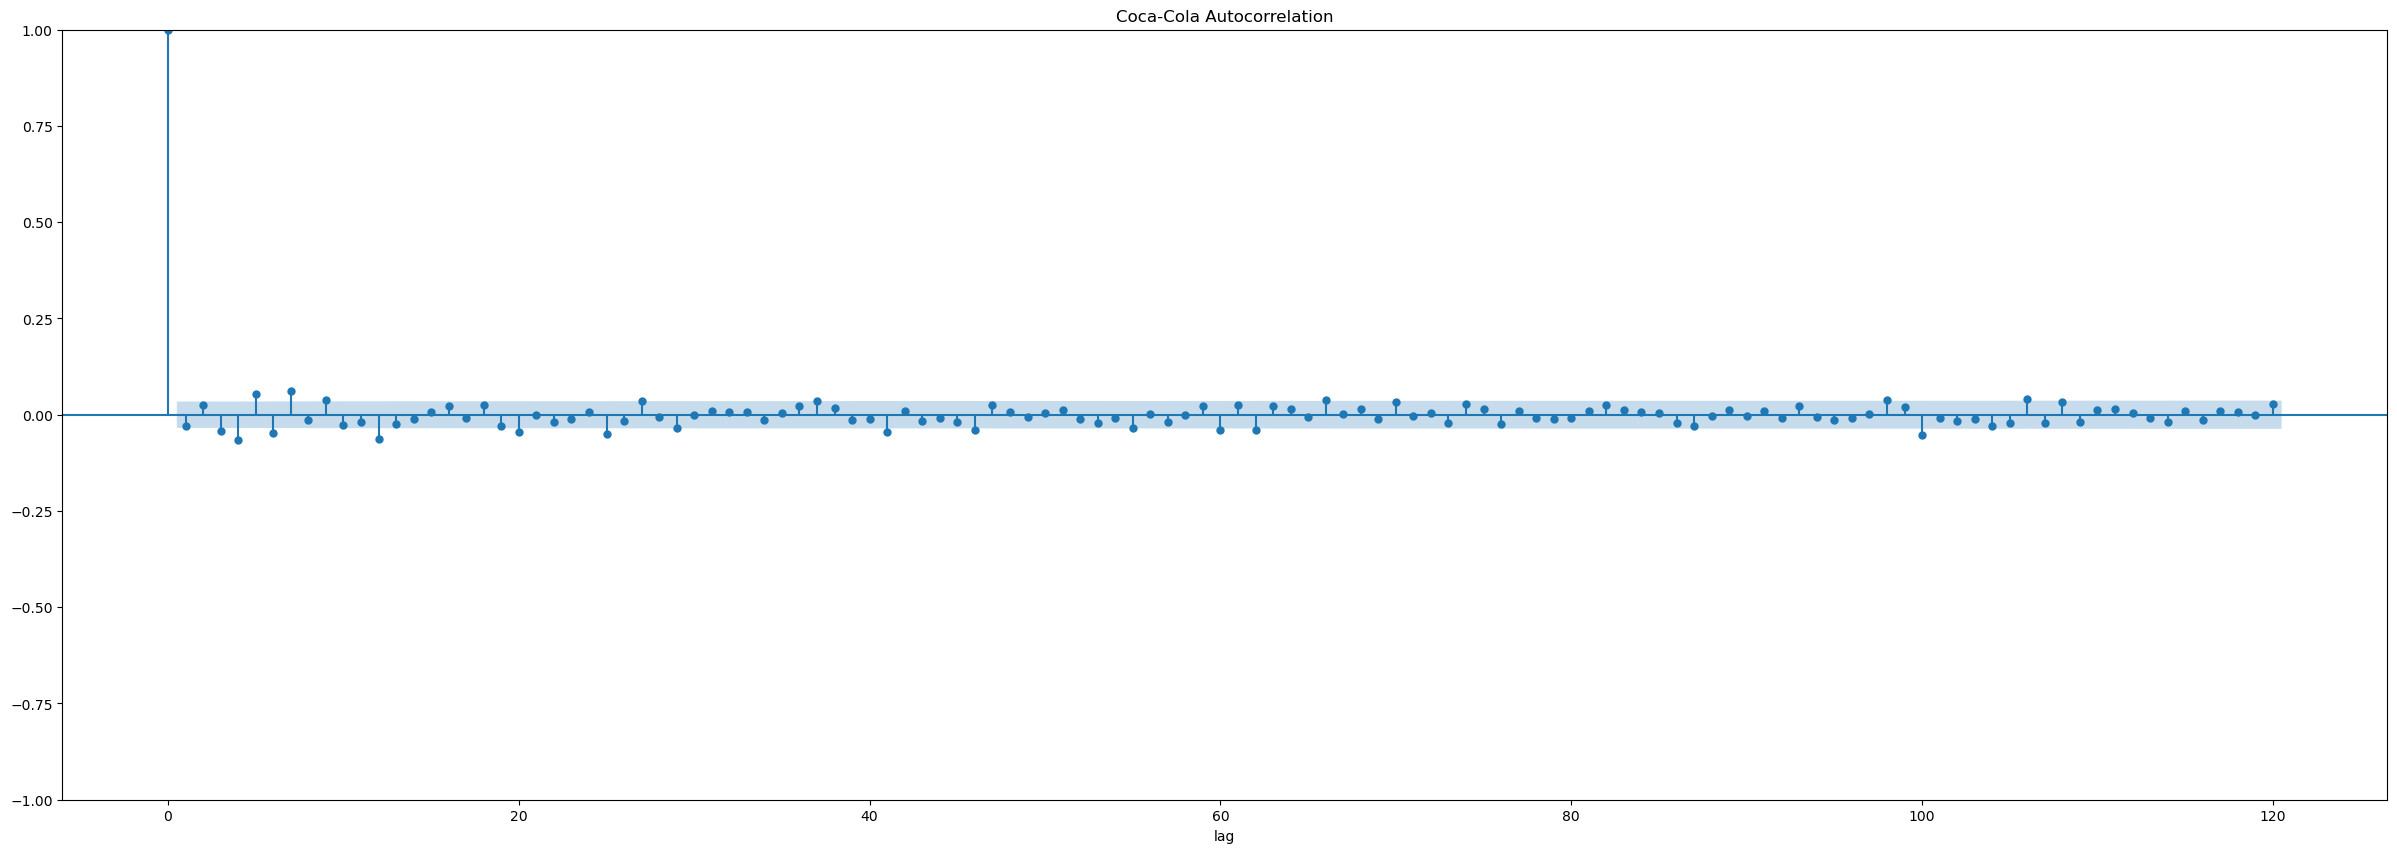

In [45]:
# ACF for stationary data for renewal phase
plt.figure(5,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_KO_Sta_Close2, lags= 120, title='Coca-Cola Autocorrelation',alpha=0.05,ax=ax);

<Figure size 3000x1000 with 0 Axes>

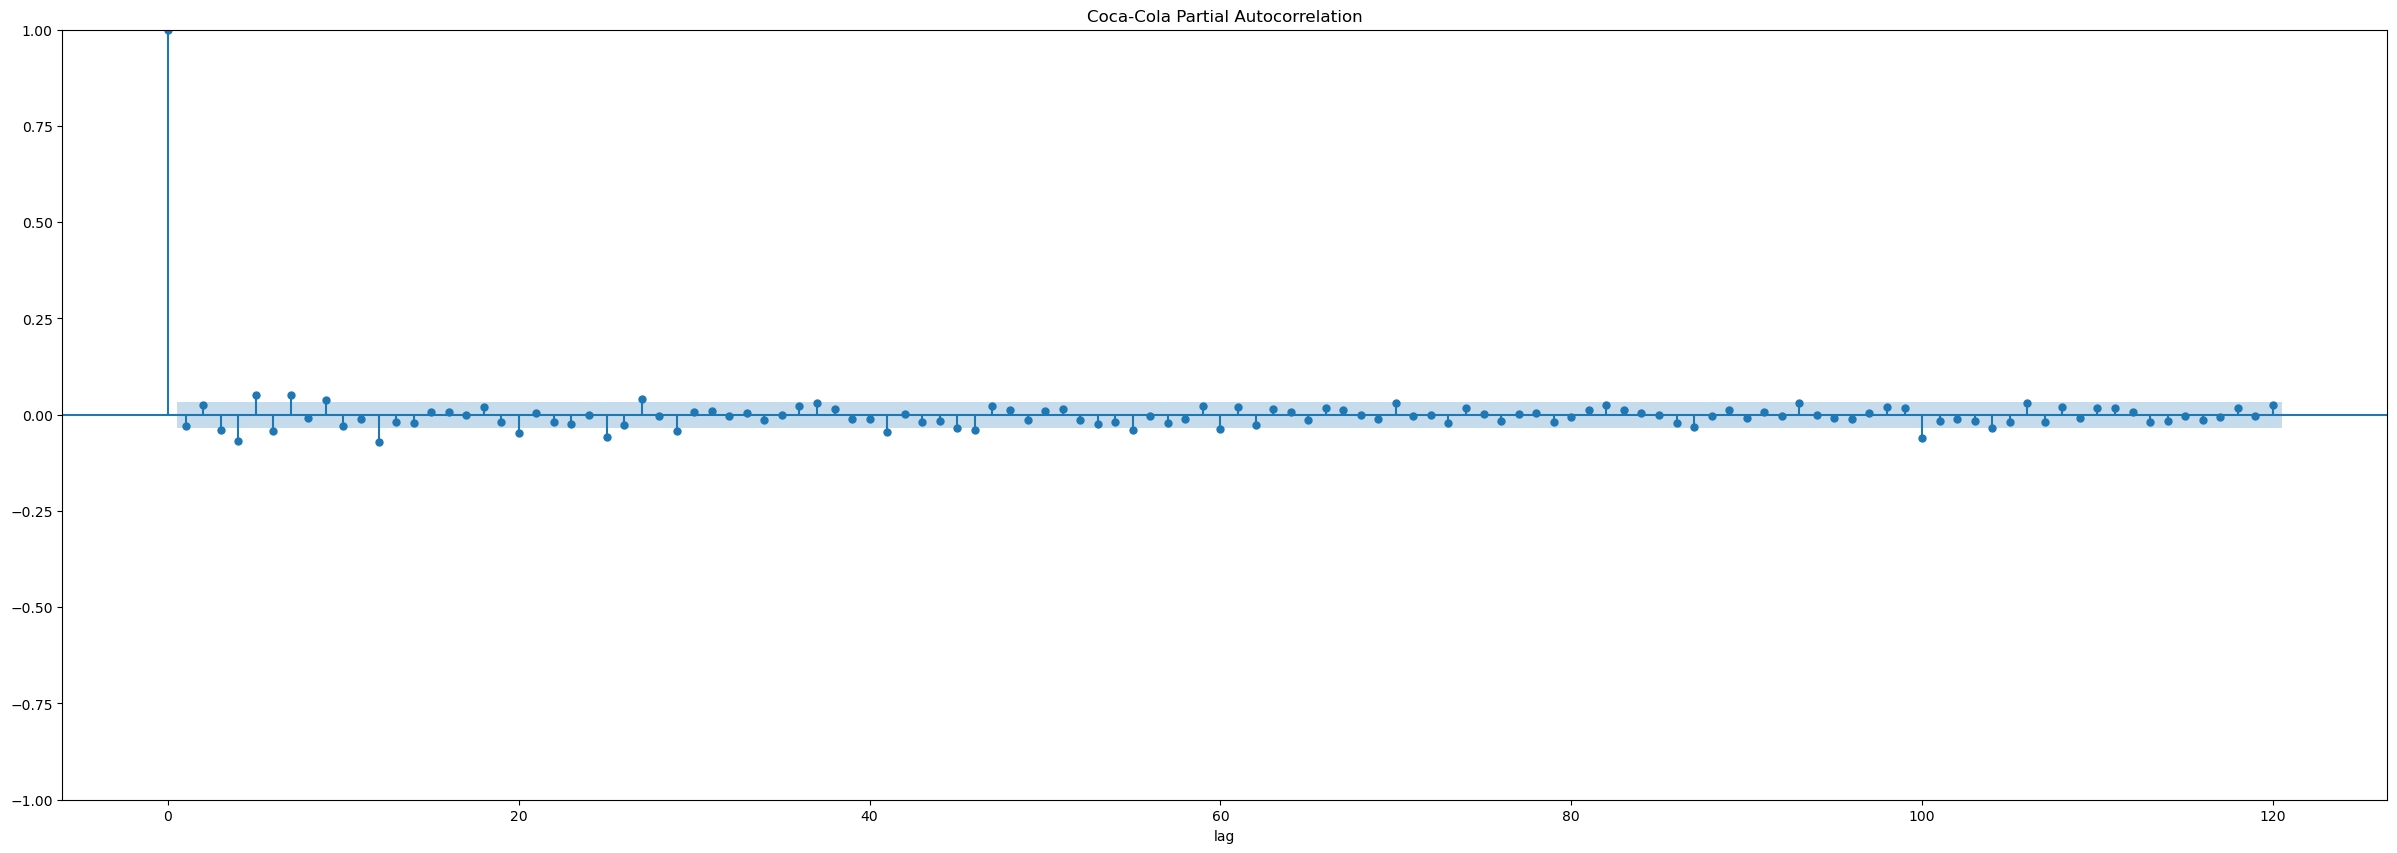

In [46]:
# PACF on stationary data for renewal phase
plt.figure(4,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_KO_Sta_Close2, lags=120 , title='Coca-Cola Partial Autocorrelation',alpha=0.05,ax=ax);

In [47]:
#parameters for our simple  SARIMA model. 

#Fitting the SARIMAX Model
model = SARIMAX(renewal_phase, 
                order=(12, 1, 12), 
                seasonal_order=(0, 1, 0, 63/4),
                enforce_stationarity=False, 
                enforce_invertibility=False)

result = model.fit() 
result.summary() 

C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                    KO   No. Observations:                 3272
Model:             SARIMAX(12, 1, 12)x(0, 1, [], 15)   Log Likelihood               -2998.222
Date:                               Tue, 17 Dec 2024   AIC                           6046.444
Time:                                       23:06:18   BIC                           6198.550
Sample:                                            0   HQIC                          6100.940
                                              - 3272                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1096      0.082      1.340      0.180      -0.051       0.270
ar.L2          0.0880      0.081      1.090      0.276      -0.070       0.246
ar.L3          0.5382      0.079      6.786      0.000       0.383       0.694
ar.L4         -0.0382      0.091     -0.420      0.675      -0.216       0.140
ar.L5         -0.0165      0.092     -0.179      0.858      -0.197       0.164
ar.L6         -0.2661      0.087     -3.053      0.002      -0.437      -0.095
ar.L7          0.2445      0.081      3.029      0.002       0.086       0.403
ar.L8         -0.2475      0.076     -3.248      0.001      -0.397      -0.098
ar.L9          0.1171      0.063      1.852      0.064      -0.007       0.241
ar.L10        -0.2451      0.044     -5.626      0.000      -0.331      -0.160
ar.L11         0.1622      0.043      3.772      0.000       0.078       0.247
ar.L12         0.0680      0.036      1.911      0.056      -0.002       0.138
ma.L1         -0.1821      0.080     -2.276      0.023      -0.339      -0.025
ma.L2         -0.0538      0.079     -0.677      0.498      -0.210       0.102
ma.L3         -0.8025      0.076    -10.492      0.000      -0.952      -0.653
ma.L4         -0.0205      0.106     -0.194      0.846      -0.228       0.187
ma.L5          0.2275      0.108      2.111      0.035       0.016       0.439
ma.L6          0.3890      0.113      3.440      0.001       0.167       0.611
ma.L7         -0.0761      0.110     -0.693      0.488      -0.291       0.139
ma.L8          0.0616      0.107      0.576      0.565      -0.148       0.271
ma.L9         -0.1461      0.097     -1.510      0.131      -0.336       0.044
ma.L10         0.2815      0.078      3.605      0.000       0.128       0.435
ma.L11        -0.2340      0.078     -3.000      0.003      -0.387      -0.081
ma.L12        -0.4471      0.066     -6.799      0.000      -0.576      -0.318
sigma2         0.3628      0.005     69.463      0.000       0.353       0.373
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10952.88
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.22   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
#Re compute the KO date index
KODateIndex2 = computeDateList(origStartDate,renewal_phase.size)



C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Shafi Hussain\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0.5, 1.0, 'ARIMA forecast horizon= 1825 steps')

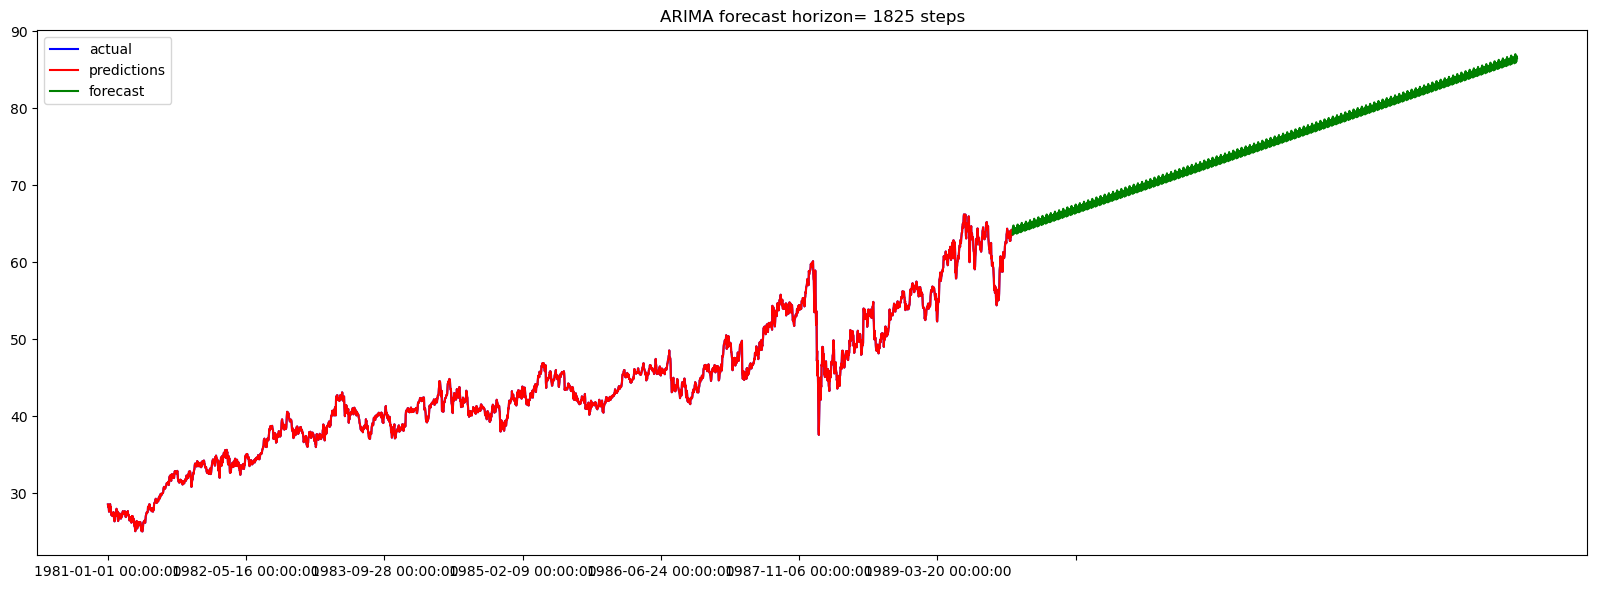

In [49]:
#######
# Use SARIMA model to do the forecast
# 
# Tinker with Series objects to properly set the index to good datetime format
####


forecastHorizon= NUM_DAYS

####
# do the forecast over time horizon (future days)
##
forecast= result.forecast(steps=forecastHorizon)

myForecast= pd.Series(forecast.values, index=forecastDateIndex)

####
# do prediction over existing time series
##
predictions= result.predict()

####
# set Series index to proper datetime formatted strings
##
myPredictions= pd.Series(renewal_phase.values, index= KODateIndex2)

myKOClose= pd.Series(renewal_phase.values, index= KODateIndex2)

####
# Visualize
###
plt.figure(12,figsize=(20,15))
plt.subplot(2,1,1)
myKOClose.plot(color='blue',label='actual')
myPredictions.plot(color='red',label='predictions')
forecast.plot(color='green',label='forecast')
plt.legend()
plt.title(f'ARIMA forecast horizon= {forecastHorizon} steps')

# TRADING


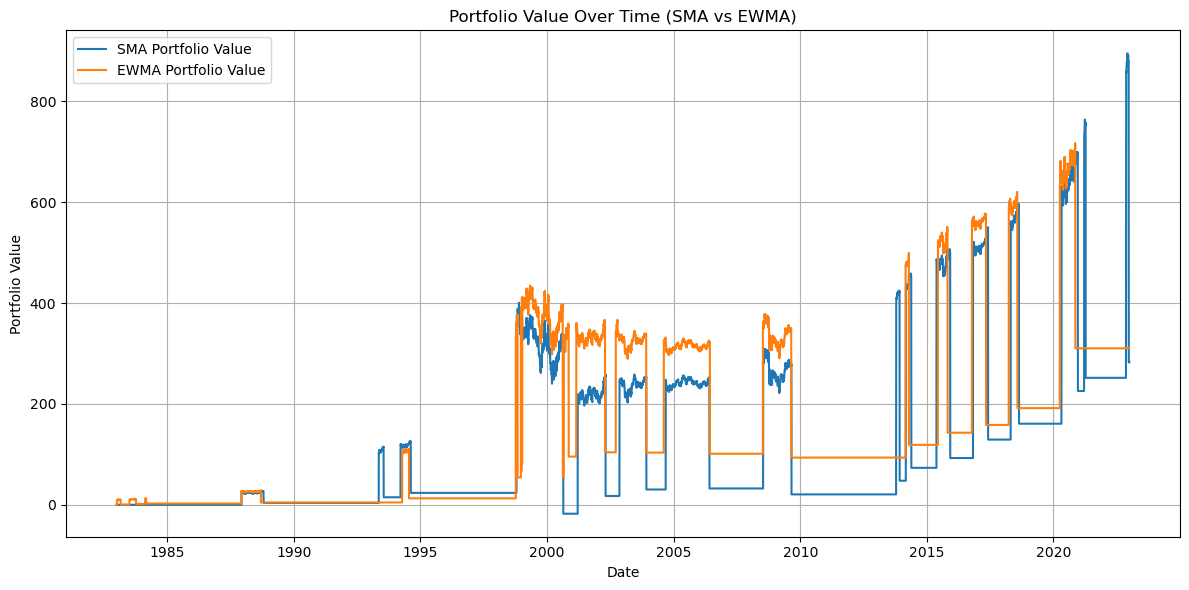

SMA Strategy Transactions:
Buy: 10 shares at $2.38 | Total Shares Owned: 10 | Total Investment: $23.75
Sell: 10 shares at $2.75, Profit: $3.75 | Total Shares Owned: 0
Buy: 10 shares at $9.94 | Total Shares Owned: 10 | Total Investment: $99.38
Sell: 10 shares at $11.06, Profit: $11.25 | Total Shares Owned: 0
Buy: 10 shares at $10.53 | Total Shares Owned: 10 | Total Investment: $105.31
Sell: 10 shares at $11.41, Profit: $8.75 | Total Shares Owned: 0
Buy: 10 shares at $33.53 | Total Shares Owned: 10 | Total Investment: $335.31
Sell: 10 shares at $29.40, Profit: $-41.33 | Total Shares Owned: 0
Buy: 10 shares at $23.72 | Total Shares Owned: 10 | Total Investment: $237.15
Sell: 10 shares at $27.23, Profit: $35.10 | Total Shares Owned: 0
Buy: 10 shares at $22.16 | Total Shares Owned: 10 | Total Investment: $221.55
Sell: 10 shares at $23.44, Profit: $12.90 | Total Shares Owned: 0
Buy: 10 shares at $21.75 | Total Shares Owned: 10 | Total Investment: $217.55
Sell: 10 shares at $21.96, Profit: $2

In [50]:
#trading function

def trading_strategy(long_avg, short_avg, prices):
    shares_owned = 0
    cumulative_profit = 0
    total_investment = 0  # Total amount invested in buying stocks
    transactions = []  # Log transactions for reference
    portfolio_value = []  # Track portfolio value over time

    # Loop through the price data
    for i in range(len(prices)):  # Include all indices
        # Skip if moving averages or prices are not available
        if i == 0 or np.isnan(long_avg[i]) or np.isnan(short_avg[i]) or np.isnan(prices[i]):
            # Append the last known portfolio value or cumulative profit
            if len(portfolio_value) > 0:
                portfolio_value.append(portfolio_value[-1])
            else:
                portfolio_value.append(cumulative_profit)
            continue

        # Buy Signal: Long-term crosses above short-term (from below)
        if long_avg[i] > short_avg[i] and long_avg[i - 1] <= short_avg[i - 1]:  # Check for crossover
            shares_owned += 10
            total_investment += 10 * prices[i]
            transactions.append(
                f"Buy: 10 shares at ${prices[i]:.2f} | Total Shares Owned: {shares_owned} | Total Investment: ${total_investment:.2f}"
            )

        # Sell Signal: Long-term crosses below short-term (from above)
        elif long_avg[i] < short_avg[i] and long_avg[i - 1] >= short_avg[i - 1] and shares_owned > 0:  # Check for crossover
            sell_price = 10 * prices[i]
            purchase_price = total_investment / shares_owned  # Average cost per share
            profit = (prices[i] - purchase_price) * 10
            cumulative_profit += profit
            shares_owned -= 10
            total_investment -= purchase_price * 10  # Remove the corresponding investment
            transactions.append(
                f"Sell: 10 shares at ${prices[i]:.2f}, Profit: ${profit:.2f} | Total Shares Owned: {shares_owned}"
            )

        # Update portfolio value
        current_value = shares_owned * prices[i] + cumulative_profit
        portfolio_value.append(current_value)

    # Final Sell: Sell all remaining stocks at the end
    if shares_owned > 0:
        final_profit = (prices[-1] - (total_investment / shares_owned)) * shares_owned
        cumulative_profit += final_profit
        transactions.append(f"Final Sell: {shares_owned} shares at ${prices[-1]:.2f}, Profit: ${final_profit:.2f}")
        shares_owned = 0
        total_investment = 0

    return portfolio_value, transactions, cumulative_profit


# Define short-term and long-term windows
long_term_window = 360
short_term_window = 60

# Calculate SMA for the specified windows
sma_long = df_KO_close.rolling(window=long_term_window).mean()
sma_short = df_KO_close.rolling(window=short_term_window).mean()

# Calculate EWMA for the specified windows
ewma_long = df_KO_close.ewm(span=long_term_window).mean()
ewma_short = df_KO_close.ewm(span=short_term_window).mean()

# Run strategy for SMA
portfolio_sma, transactions_sma, profit_sma = trading_strategy(sma_long.values, sma_short.values, df_KO_close.values)

# Run strategy for EWMA
portfolio_ewma, transactions_ewma, profit_ewma = trading_strategy(ewma_long.values, ewma_short.values, df_KO_close.values)

# Plotting the portfolio values
plt.figure(figsize=(12, 6))
plt.plot(df_KO_close.index, portfolio_sma, label="SMA Portfolio Value")
plt.plot(df_KO_close.index, portfolio_ewma, label="EWMA Portfolio Value")
plt.title("Portfolio Value Over Time (SMA vs EWMA)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Summary of transactions and profits
print("SMA Strategy Transactions:")
print("\n".join(transactions_sma))
print(f"Total Profit (SMA): ${profit_sma:.2f}")

print("\nEWMA Strategy Transactions:")
print("\n".join(transactions_ewma))
print(f"Total Profit (EWMA): ${profit_ewma:.2f}")


In [51]:
#convert noisy_forecast to a date time object

noisy_forecast_series.index = pd.date_range(
    start=df_KO_close.index[-1] + pd.Timedelta(days=1),
    periods=len(noisy_forecast_series),
    freq='D'
)

Original df_KO_close length: 10084
Extended df_KO_close length: 11909


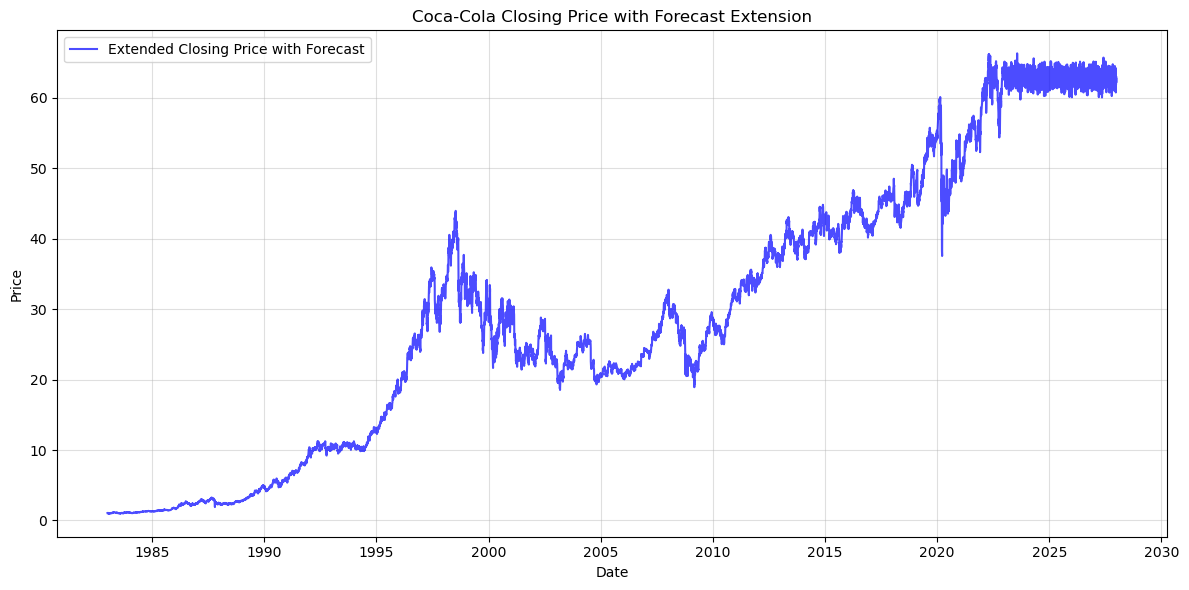

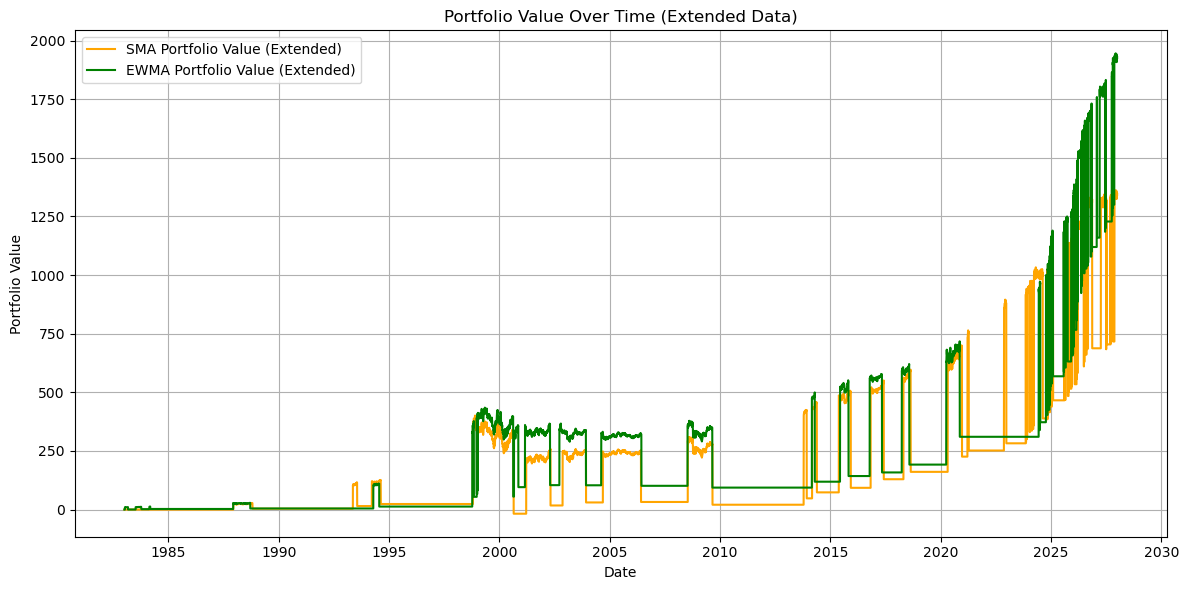

SMA Strategy Transactions (Extended Data):
Buy: 10 shares at $2.38 | Total Shares Owned: 10 | Total Investment: $23.75
Sell: 10 shares at $2.75, Profit: $3.75 | Total Shares Owned: 0
Buy: 10 shares at $9.94 | Total Shares Owned: 10 | Total Investment: $99.38
Sell: 10 shares at $11.06, Profit: $11.25 | Total Shares Owned: 0
Buy: 10 shares at $10.53 | Total Shares Owned: 10 | Total Investment: $105.31
Sell: 10 shares at $11.41, Profit: $8.75 | Total Shares Owned: 0
Buy: 10 shares at $33.53 | Total Shares Owned: 10 | Total Investment: $335.31
Sell: 10 shares at $29.40, Profit: $-41.33 | Total Shares Owned: 0
Buy: 10 shares at $23.72 | Total Shares Owned: 10 | Total Investment: $237.15
Sell: 10 shares at $27.23, Profit: $35.10 | Total Shares Owned: 0
Buy: 10 shares at $22.16 | Total Shares Owned: 10 | Total Investment: $221.55
Sell: 10 shares at $23.44, Profit: $12.90 | Total Shares Owned: 0
Buy: 10 shares at $21.75 | Total Shares Owned: 10 | Total Investment: $217.55
Sell: 10 shares at $2

In [52]:
# Add `myForecast` at the end of `df_KO_close` and re runs the trading function
# Ensure the indices do not overlap to avoid confusion
extended_df_KO_close = pd.concat([df_KO_close, noisy_forecast_series])

# Verify the updated series
print("Original df_KO_close length:", len(df_KO_close))
print("Extended df_KO_close length:", len(extended_df_KO_close))

# Plot the extended data
plt.figure(figsize=(12, 6))
plt.plot(extended_df_KO_close, label="Extended Closing Price with Forecast", color="blue", alpha=0.7)
plt.title("Coca-Cola Closing Price with Forecast Extension")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Run the trading algorithm on the extended series
# Define short-term and long-term windows
long_term_window = 360
short_term_window = 60

# Calculate SMA for the specified windows on the extended series
sma_long = extended_df_KO_close.rolling(window=long_term_window).mean()
sma_short = extended_df_KO_close.rolling(window=short_term_window).mean()

# Calculate EWMA for the specified windows on the extended series
ewma_long = extended_df_KO_close.ewm(span=long_term_window).mean()
ewma_short = extended_df_KO_close.ewm(span=short_term_window).mean()

# Run strategy for SMA
portfolio_sma_extended, transactions_sma_extended, profit_sma_extended = trading_strategy(
    sma_long.values, sma_short.values, extended_df_KO_close.values
)

# Run strategy for EWMA
portfolio_ewma_extended, transactions_ewma_extended, profit_ewma_extended = trading_strategy(
    ewma_long.values, ewma_short.values, extended_df_KO_close.values
)

# Plotting the portfolio values
plt.figure(figsize=(12, 6))
plt.plot(extended_df_KO_close.index, portfolio_sma_extended, label="SMA Portfolio Value (Extended)", color="orange")
plt.plot(extended_df_KO_close.index, portfolio_ewma_extended, label="EWMA Portfolio Value (Extended)", color="green")
plt.title("Portfolio Value Over Time (Extended Data)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Summary of transactions and profits
print("SMA Strategy Transactions (Extended Data):")
print("\n".join(transactions_sma_extended))
print(f"Total Profit (SMA, Extended Data): ${profit_sma_extended:.2f}")

print("\nEWMA Strategy Transactions (Extended Data):")
print("\n".join(transactions_ewma_extended))
print(f"Total Profit (EWMA, Extended Data): ${profit_ewma_extended:.2f}")
